## Import packages/libraries

In [76]:
library(reshape2)
library(xtable)

## Plot
library(ggplot2)

source("../functions.R")

## Import data

#### Majority of the probesets of HG-95Av2 differ from HG-U133

In [56]:
## Raw data
RAW1_RPATH <- "data/yeoh_2002/processed/mas5_original.tsv"
raw <- read.table(RAW1_RPATH, header = T, sep = "\t")

## Metadata
METADATA1_RPATH <- "data/yeoh_2002/processed/metadata2.tsv"
metadata <- read.table(METADATA1_RPATH, header = T, sep = "\t",
                       comment.char = "", row.names = 1)

# SCALE->REMOVE->FILTER->LOG
X_scaled <- normaliseMeanScaling(raw)
X_selected <- removeProbesets(X_scaled)
data <- log2_transform(filterProbesets(X_selected, 0.7))

     N01      N02      N03      N04      N05      N06 
34.22921 11.90918 17.29122 16.39706 35.61220 31.38095 
[1] "No. of ambiguous and AFFY probesets removed: 2580"
[1] "No. of probesets removed = 8721"


## Chr annotation

In [57]:
# ## Annotation: Chr location
ANNOT_RPATH <- "../info/microarray/HG-U95Av2/affymetrix/HG_U95Av2.na36.annot.csv"
annot <- read.csv(ANNOT_RPATH,  row.names = 1, comment.char = "#")

get_chrloc <- function(ps, annot) {
  ps_chrloc <- annot[ps, "Chromosomal.Location"]
  ps_chr <- sub("(chr.*?)(p|q|c).*", "\\1", ps_chrloc)
  ps_chr[ps_chr == "---"] <- NA
  names(ps_chr) <- ps
  return(ps_chr)
}

## Get mapped chr location of probesets
ps_chr <- get_chrloc(rownames(data), annot)
print(length(ps_chr))

[1] 1324


## Subset data

NB: Normal refers to karyotype not "normal patient"

In [58]:
dim(hyperdiploid)

[1] 1018   65

In [59]:
## Normal
idx_normal <- metadata[colnames(data), "subtype"] == "Normal"
normal <- data[,idx_normal]

## Hyperdiploid
idx_hyp <- metadata[colnames(data), "subtype"] == "Hyperdiploid (>50)"
hyperdiploid <- data[,idx_hyp]

Remove patients with high percentage of zeros

In [60]:
pid_na <- sprintf("A%02d", 1:14) # no relapse labels
# A88 not included for reasons stated in suppl data
pid_outlier <- c("A39", "A62", "A88", "N01", "N05", "N07", "N11", "N13") # high pct of zeros
pid_rm <- c(pid_na, pid_outlier)

normal1 <- normal[,!(colnames(normal) %in% pid_rm)]
hyperdiploid1 <- hyperdiploid[,!(colnames(hyperdiploid) %in% pid_rm)]

## Summary statistics

In [64]:
sapply(list_chr_hyp, nrow)

chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19  chr2 chr20 
  146    42    94    77    15    49    24    56    86    15   106    85    23 
chr21 chr22  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chrX  chrY 
   20    39    63    34    70    82    53    41    43    56     1

In [65]:
### NORMAL
list_chr_norm <- split.data.frame(normal1, ps_chr)
## MEDIAN
norm_median <- t(sapply(list_chr_norm, apply, 2, median))[1:22,]
## MEDIAN (NO ZERO)
norm_fltr1_median <- t(sapply(list_chr_norm, apply, 2,
                              function(vec) median(vec[vec != 0])))[1:22,]
# ## PCT ZERO
# norm_pct_zero <- t(sapply(list_chr_norm, apply, 2,
#                      function(vec) sum(vec == 0)/length(vec)))[1:22,]

### HYPERDIPLOID
list_chr_hyp <- split.data.frame(hyperdiploid1, ps_chr)
## MEDIAN
hyp_median <- t(sapply(list_chr_hyp, apply, 2, median))[1:22,]
## MEDIAN (NO ZERO)
hyp_fltr1_median <- t(sapply(list_chr_hyp, apply, 2,
                             function(vec) median(vec[vec != 0])))[1:22,]
# ## PCT ZERO
# hyp_pct_zero <- t(sapply(list_chr_hyp, apply, 2,
#                          function(vec) sum(vec == 0)/length(vec)))[1:22,]
print(rownames(hyp_median))

 [1] "chr1"  "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17"
[10] "chr18" "chr19" "chr2"  "chr20" "chr21" "chr22" "chr3"  "chr4"  "chr5" 
[19] "chr6"  "chr7"  "chr8"  "chr9" 


In [66]:
## FUNCTIONS
#' @param wpath DO NOT INCLUDE .pdf (>1 file is saved)
#' @param m number of plots per page
plot_chr_hyp2 <- function(X_subtype, X_norm, wpath, m = 20) {
  X <- cbind(X_subtype, X_norm)
  n <- ncol(X)
  
  long_chr <- melt(data.matrix(X), varnames = c("chr", "pid"))
  long_chr$chr <- factor(long_chr$chr,
                         levels = levels(long_chr$chr)[
                           c(1,12,16:22,2:11,13:15,23)])
  y_lim <- c(floor(min(X)), ceiling(max(X)))

  ## Create color map for chr
  g1_chr <- c("chr4", "chr6", "chr10", "chr14", "chr17",
              "chr18", "chr21", "chrX")
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  col_chr <- setdiff(g1_chr, "chrX")
  all_chr <- paste0("chr", 1:22)
  nocol_chr <- setdiff(all_chr, col_chr)
  nocol_chr <- setdiff(all_chr, c(col_chr, g4_chr))
  col_map <- c(rep("darkolivegreen3", length(col_chr)),
               rep("tomato3", length(g4_chr)),
               rep("black", 22-length(col_chr)-length(g4_chr)))
  names(col_map) <- c(col_chr, g4_chr, nocol_chr)
  
  n_plot <- ceiling(n/m)
  
  for (i in 1:(n_plot-1)) {
    start <- (i-1)*m*22+1
    end <- i*m*22
    X_plot <- long_chr[start:end,]
    wpath1 <- sprintf("%s_%d.pdf", wpath, i)
    
    jitter1 <- ggplot(X_plot, aes(chr, value, color = chr)) +
      geom_point(position = position_jitter(width=.1, height=0),
                 cex = 2, show.legend = F) +
      facet_wrap(~pid, nrow = 4, ncol = 5,  scales = "free_x") +
      theme(axis.title.x=element_blank(),
            axis.title.y=element_blank(),
            axis.text.x=element_text(angle = 90, vjust = 0.5)) +
      scale_color_manual(values = col_map) +
      ylim(y_lim[1], y_lim[2])
    
    ggsave(wpath1, jitter1, width = 16, height = 10)
  }
  
  start <- (n_plot-1)*m*22+1
  end <- nrow(long_chr)
  X_plot <- long_chr[start:end,]
  jitter2 <- ggplot(X_plot, aes(chr, value, color = chr)) +
    geom_point(position = position_jitter(width=.1, height=0),
               cex = 2, show.legend = F) +
    facet_wrap(~pid, nrow = 4, ncol = 5,  scales = "free_x") +
    theme(axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          axis.text.x=element_text(angle = 90, vjust = 0.5)) +
    scale_color_manual(values = col_map) +
    ylim(y_lim[1], y_lim[2])

  wpath2 <- sprintf("%s_%d.pdf", wpath, n_plot)
  ggsave(wpath2, jitter2, width = 16, height = 10)
}


#' @param X_subtype dataframe of chr statistics containing only subtype patients
#' @param X_norm dataframe of chr statistics containing only subtype patients
plot_heatmap_batch <- function(X_subtype, X_norm, metadata, filename) {
  if (endsWith(colnames(X_subtype)[1], "D0"))
      stop("Colnames already suffixed with D0!")

  subset_metadata <- metadata[,c("batch_info", "subtype", "label"), drop = F]

  colnames(X_subtype) <- paste(colnames(X_subtype), "D0", sep = "_")
  ord_idx <- order(metadata[colnames(X_subtype), "batch_info"])
  X_subtype_ord <- X_subtype[,ord_idx]
  gaps <- cumsum(table(metadata[colnames(X_subtype), "batch_info"]))
  X_ord <- cbind(X_subtype_ord, X_norm)

  pheatmap(X_ord, col = brewer.pal(9, "Blues"),
           display_numbers = F, fontsize = 5.5,
           legend = T, border_color = "black", scale = "none",
           cluster_method = "ward.D2", cluster_rows = F, cluster_cols = F,
           show_colnames = T, show_rownames = T,
           annotation_col = subset_metadata,
           gaps_col = gaps, cellwidth = 8, cellheight = 10,
           filename = filename)
  cat("Heatmap saved!\n")
}

#### Plot: Chr median

In [249]:
plot_chr_hyp2(hyp_fltr1_median, norm_fltr1_median, "~/Dropbox/temp/yeoh_2002-fltr1_median")

## Test statistics

#### Z-score (N14)

In [79]:
## Chr: Median (fltr)
## Determine mean and sd of chr medians of normal
ref_normal <- norm_fltr1_median[,"N14"]
ref_mean <- mean(ref_normal)
ref_sd <- sd(ref_normal)

hyp_fltr1_median_std <- (hyp_fltr1_median-ref_mean)/ref_sd
norm_fltr1_median_std <- (norm_fltr1_median-ref_mean)/ref_sd

In [83]:
## Chr: Median
## Determine mean and sd of chr medians of normal
ref_normal <- norm_median[,"N14"]
ref_mean <- mean(ref_normal)
ref_sd <- sd(ref_normal)

hyp_median_std <- (hyp_median-ref_mean)/ref_sd
norm_median_std <- (norm_median-ref_mean)/ref_sd

## Risk classification

In [54]:
## Hyperdiploid - Risk classification --------------------------------------
# normal_pid <- paste0("N0", c(1,2,4))

#' @param X_chr Chromosomal summary of hyp and normal patients
#' @return Ranked chr of hyp patients only (only ranks autosomal chr)
rank_chr <- function(X_chr) {
  chr_rank <- apply(-X_chr[1:22,], 2, function(x) names(sort(x)))
  return(chr_rank)
}

#' @param chr_rank Ranked chr (does not include normal patients)
#' Returns pid of patients with top 4 chr in G4
get_pid_toprank <- function(chr_rank, n_rank) {
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  top_chr <- chr_rank[1:n_rank,]
  list_topchr <- as.list(data.frame(top_chr))
  idx_topchr <- sapply(list_topchr, function(x) any(x %in% g4_chr))
  return(names(list_topchr[idx_topchr]))
}

#' @param X_subtype dataframe of chr summary containing only subtype patients
#' @param lower logical indicating if only lower threshold is to be used
#' @return patient IDs
get_pid_threshold <- function(X_subtype, threshold, lower) {
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  ## OPTION: Only group 4 chr
  ## g4_chr <- "chr13"
  ## X_fltr <- X_subtype[rownames(X_subtype) == g4_chr, , drop = F]
  X_fltr <- X_subtype[rownames(X_subtype) %in% g4_chr,]
  if (!lower) {
    idx_logi <- abs(X_fltr) > threshold
  } else {
    stopifnot(threshold < 0)
    idx_logi <- X_fltr < threshold
  }
  pid_idx_logi <- apply(idx_logi, 2, any)
  return(names(pid_idx_logi)[pid_idx_logi])
}

get_list_pid <- function(pid, pid_hyp) {
  if (length(pid) == 0) stop("Empty list...")
  ## Assumption: Colnames of hyperdiploid has no D0/D8
  pid_not <- setdiff(pid_hyp, pid)
  return(list(pid, pid_not))
}

#' Pastes D0 and D8 to pid
convert_list_pid <- function(list_pid) {
  lapply(list_pid, function(x) c(paste(x, "D0", sep = "_"),
                                 paste(x, "D8", sep = "_")))
}

#' @param list_pid list with first element containing high risk
#' patient ids and second element containing low risk patient ids
create_table <- function(list_pid) {
  relapse_pid <- c("A15", "A16", "A60", "A61", "A63", "A64")
  a <- sum(list_pid[[1]] %in% relapse_pid)
  b <- length(list_pid[[1]]) - a
  c <- sum(list_pid[[2]] %in% relapse_pid)
  d <- length(list_pid[[2]]) - c

  if (a < 4)
    warning("list_pid does not contain high risk patients in first element!")

  table_dimnames <- list(c("HR", "LR"),
                         c("Relapse", "Remission"))
  matrix(c(a, c, b, d), nrow = 2, dimnames = table_dimnames)
}

#' @return list of 2 with vector of high risk pids and
#' vector of low risk pids
stratify_risk <- function(p, threshold) {
  names(p) <- substring(names(p), 1, 4)
  idx <- p > threshold # high risk
  list(names(p)[idx], names(p)[!idx])
}

#### Rule-based classification

In [80]:
## Chr: Median (fltr)
X <- hyp_fltr1_median_std

## Filter (drug-batch) - Median - Z-score (N01)
## HR: Top 4 in G4 OR Any G4 abs(chr) < threshold
pid_threshold <- get_pid_threshold(X, -2.7, lower = T)

rank_hyp_median <- rank_chr(X)
pid_top_hyp <- get_pid_toprank(rank_hyp_median, 4)
pid_union <- union(pid_threshold, pid_top_hyp)

list_pid <- get_list_pid(pid_union, colnames(X))
tab <- create_table(list_pid)
fisher <- fisher.test(tab)
chisq <- chisq.test(tab)

print(pid_threshold)
print(pid_top_hyp)

print(tab)
print(xtable(tab))
print(chisq)
print(fisher)

Warning message in chisq.test(tab):
“Chi-squared approximation may be incorrect”

character(0)
 [1] "A15" "A16" "A17" "A18" "A20" "A21" "A22" "A23" "A24" "A26" "A27" "A29"
[13] "A31" "A32" "A33" "A34" "A36" "A37" "A38" "A41" "A42" "A44" "A45" "A46"
[25] "A49" "A50" "A51" "A53" "A54" "A55" "A56" "A57" "A58" "A59" "A60" "A61"
[37] "A64"
   Relapse Remission
HR       5        32
LR       1        10
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Tue Jan 19 15:43:12 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & Relapse & Remission \\ 
  \hline
HR &   5 &  32 \\ 
  LR &   1 &  10 \\ 
   \hline
\end{tabular}
\end{table}

	Pearson's Chi-squared test with Yates' continuity correction

data:  tab
X-squared = 0, df = 1, p-value = 1


	Fisher's Exact Test for Count Data

data:  tab
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.145984 81.160282
sample estimates:
odds ratio 
  1.549405 



In [73]:
## Chr: Median
X <- hyp_median_std

## Filter (drug-batch) - Median - Z-score (N01)
## HR: Top 4 in G4 OR Any G4 abs(chr) < threshold
pid_threshold <- get_pid_threshold(X, -2.7, lower = T)

rank_hyp_median <- rank_chr(X)
pid_top_hyp <- get_pid_toprank(rank_hyp_median, 2)
pid_union <- union(pid_threshold, pid_top_hyp)

list_pid <- get_list_pid(pid_union, colnames(X))
tab <- create_table(list_pid)
fisher <- fisher.test(tab)
chisq <- chisq.test(tab)

print(pid_threshold)
print(pid_top_hyp)

print(tab)
print(chisq)
print(fisher)

ERROR: Error in eval(expr, envir, enclos): object 'hyp_median_std' not found


## EDA

### Plot all probesets (by chr)

[1] "A62"


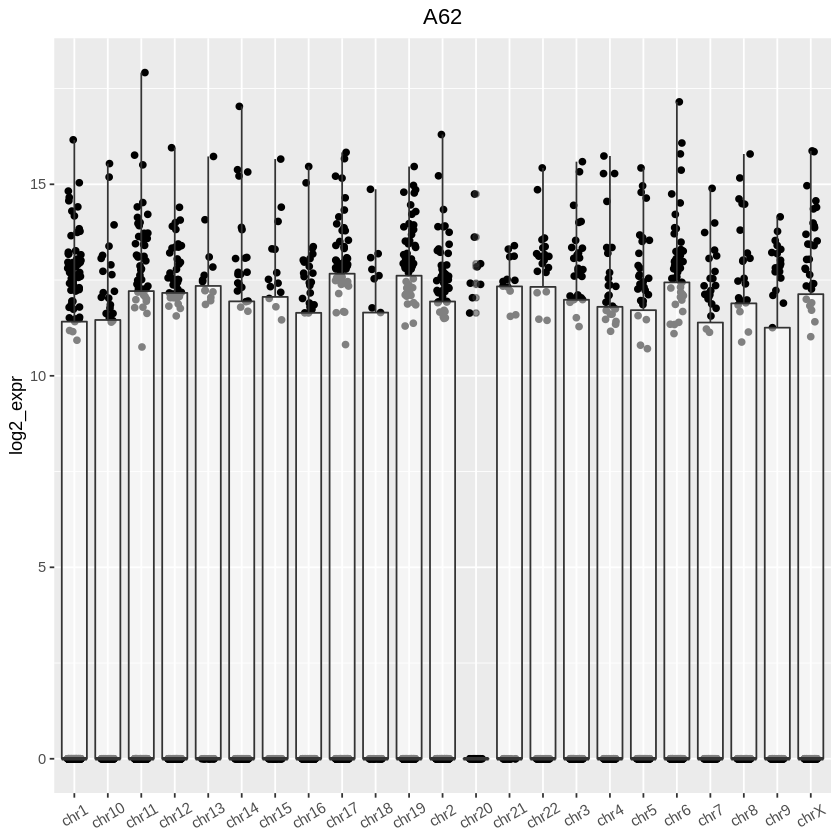

In [118]:
# Plot all genes by chr
hyp_chr <- cbind(chr = ps_chr, hyperdiploid)
chr_idx <- !(ps_chr %in% c("chrY", NA))


for (pid in colnames(hyperdiploid)) {
  pid <- "A62"
  print(pid)
  plot_data <- droplevels(hyp_chr[chr_idx, c("chr", pid)])
  colnames(plot_data) <- c("chr", "log2_expr")
  # plot_data <- plot_data[plot_data$log2_expr != 0,]
  
  groupby_chr <- ggplot(plot_data, aes(chr, log2_expr)) +
    geom_point(position = position_jitter(width=.2, height=0)) +
    geom_boxplot(alpha=.5) +
    ggtitle(pid) +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(angle = 30, vjust = 0.5),
          plot.title = element_text(hjust = 0.5))
  WPATH <- sprintf("~/Dropbox/temp/%s.pdf", pid)
  groupby_chr
  break
  ggsave(WPATH, groupby_chr, width = 12, height = 6)
}

groupby_chr

### Plot: MA

In [21]:
#' @param x1 vector of log2 transformed values of sample x1
#' @param x2 vector of log2 transformed values of sample x2
plot_ma <- function(x1, x2, trim = .3, title = NULL) {
  # Filter out features that are 0 in x1 or x2
  idx <- x1*x2 != 0
  fltr_x1 <- x1[idx]
  fltr_x2 <- x2[idx]
  
  M <- fltr_x1-fltr_x2
  A <- .5*(fltr_x1+fltr_x2)
  
  # Ignores minority of genes which are DE
  TMM <- mean(M, trim = trim) # robust estimator for central tendency
  MM <- mean(M)
  MedianM <- median(M)
  SD <- sd(M)
  
  main <- sprintf("%s [mean = %.3f, sd = %.3f]",
                  title, MM, SD) # include mean and sd in title
  
  par(mfrow = c(1,2))
  plot(A, M, cex = .6, main = main)
  abline(h = TMM, col = "green")
  abline(h = MM, col = "red")
  abline(h = MedianM, col = "purple")
  hist(M)
  abline(v = TMM, col = "green")
  abline(v = MM, col = "red")
  abline(v = MedianM, col = "purple")
  par(mfrow = c(1,1))
}

In [44]:
metadata[colnames(hyperdiploid1),]

original_names    scan_date  class_info         outcome      label
A15 Hyperdip-50-2M#1  2001-03-27 Hyperdiploid (>50) 2nd AML      1    
A16 Hyperdip-50-2M#2  2001-04-17 Hyperdiploid (>50) 2nd AML      1    
A17 Hyperdip-50-C1    2001-04-25 Hyperdiploid (>50) CCR          0    
A18 Hyperdip-50-C10   2001-05-04 Hyperdiploid (>50) CCR          0    
A19 Hyperdip-50-C11   2001-09-10 Hyperdiploid (>50) CCR          0    
A20 Hyperdip-50-C12   2001-05-08 Hyperdiploid (>50) CCR          0    
A21 Hyperdip-50-C13   2001-07-13 Hyperdiploid (>50) CCR          0    
A22 Hyperdip-50-C14   2001-06-27 Hyperdiploid (>50) CCR          0    
A23 Hyperdip-50-C15   2001-05-09 Hyperdiploid (>50) CCR          0    
A24 Hyperdip-50-C16   2001-05-11 Hyperdiploid (>50) CCR          0    
A25 Hyperdip-50-C17   2001-03-15 Hyperdiploid (>50) CCR          0    
A26 Hyperdip-50-C18   2001-03-19 Hyperdiploid (>50) CCR          0    
A27 Hyperdip-50-C19   2001-03-19 Hyperdiploid (>50) CCR          0    
A28 Hyperdip-50-C2    2001-04-25 Hyperdiploid (>50) CCR          0    
A29 Hyperdip-50-C20   2001-03-21 Hyperdiploid (>50) CCR          0    
A30 Hyperdip-50-C21   2001-03-22 Hyperdiploid (>50) CCR          0    
A31 Hyperdip-50-C22   2001-03-29 Hyperdiploid (>50) CCR          0    
A32 Hyperdip-50-C23   2001-03-29 Hyperdiploid (>50) CCR          0    
A33 Hyperdip-50-C24   2001-04-17 Hyperdiploid (>50) CCR          0    
A34 Hyperdip-50-C25   2001-04-17 Hyperdiploid (>50) CCR          0    
A35 Hyperdip-50-C26   2001-04-24 Hyperdiploid (>50) CCR          0    
A36 Hyperdip-50-C27-N 2001-04-17 Hyperdiploid (>50) CCR          0    
A37 Hyperdip-50-C28   2001-09-11 Hyperdiploid (>50) CCR          0    
A38 Hyperdip-50-C29   2001-04-03 Hyperdiploid (>50) CCR          0    
A40 Hyperdip-50-C30   2001-04-03 Hyperdiploid (>50) CCR          0    
A41 Hyperdip-50-C31   2001-04-03 Hyperdiploid (>50) CCR          0    
A42 Hyperdip-50-C32   2001-09-11 Hyperdiploid (>50) CCR          0    
A43 Hyperdip-50-C33   2001-07-03 Hyperdiploid (>50) CCR          0    
A44 Hyperdip-50-C34   2001-04-18 Hyperdiploid (>50) CCR          0    
A45 Hyperdip-50-C35   2001-05-30 Hyperdiploid (>50) CCR          0    
A46 Hyperdip-50-C36   2001-03-09 Hyperdiploid (>50) CCR          0    
A47 Hyperdip-50-C37   2001-04-03 Hyperdiploid (>50) CCR          0    
A48 Hyperdip-50-C38   2001-03-09 Hyperdiploid (>50) CCR          0    
A49 Hyperdip-50-C39   2001-03-09 Hyperdiploid (>50) CCR          0    
A50 Hyperdip-50-C4    2001-04-26 Hyperdiploid (>50) CCR          0    
A51 Hyperdip-50-C40   2001-04-18 Hyperdiploid (>50) CCR          0    
A52 Hyperdip-50-C41   2001-03-14 Hyperdiploid (>50) CCR          0    
A53 Hyperdip-50-C42   2001-03-15 Hyperdiploid (>50) CCR          0    
A54 Hyperdip-50-C43   2001-09-12 Hyperdiploid (>50) CCR          0    
A55 Hyperdip-50-C5    2001-04-27 Hyperdiploid (>50) CCR          0    
A56 Hyperdip-50-C6    2001-06-29 Hyperdiploid (>50) CCR          0    
A57 Hyperdip-50-C7    2001-05-31 Hyperdiploid (>50) CCR          0    
A58 Hyperdip-50-C8    2001-06-29 Hyperdiploid (>50) CCR          0    
A59 Hyperdip-50-C9    2001-08-20 Hyperdiploid (>50) CCR          0    
A60 Hyperdip-50-R1    2001-03-27 Hyperdiploid (>50) Heme relapse 1    
A61 Hyperdip-50-R2    2001-03-28 Hyperdiploid (>50) Heme relapse 1    
A63 Hyperdip-50-R4    2001-03-07 Hyperdiploid (>50) Heme relapse 1    
A64 Hyperdip-50-R5    2001-06-01 Hyperdiploid (>50) Heme relapse 1

In [31]:
colnames(normal1)

[1] "N02" "N03" "N04" "N06" "N08" "N09" "N10" "N12" "N14" "N15" "N16" "N17"
[13] "N18" "N19"

#### Plot: All probesets

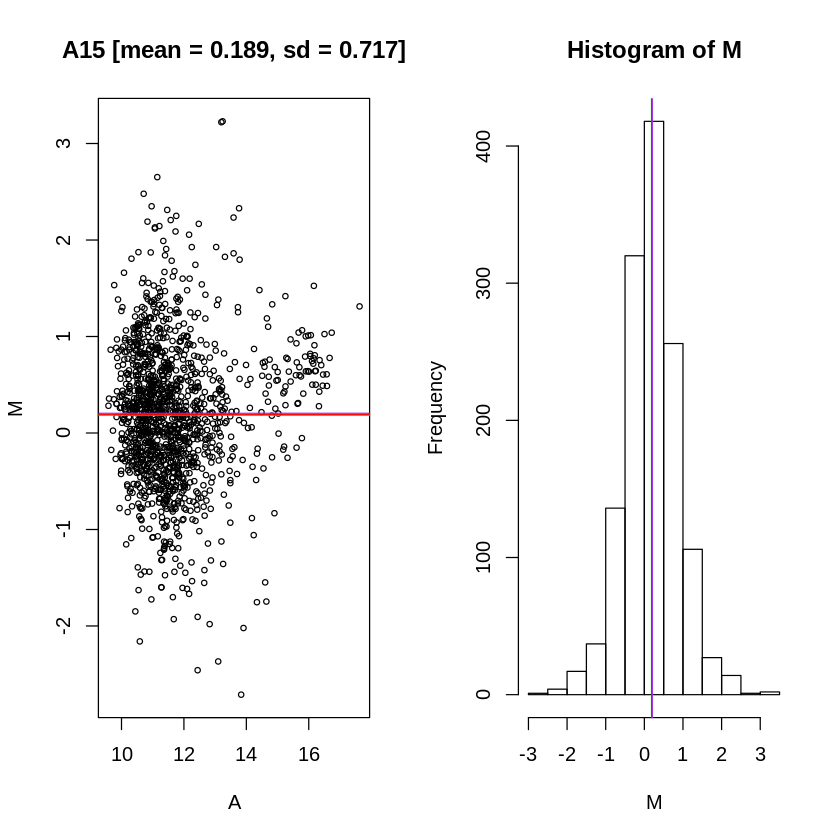

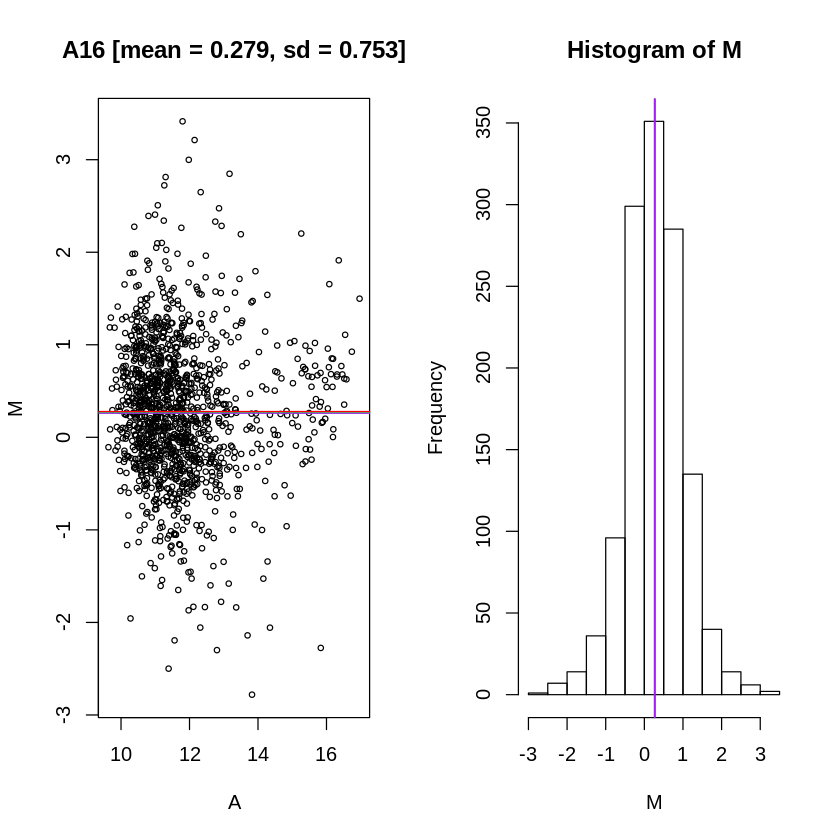

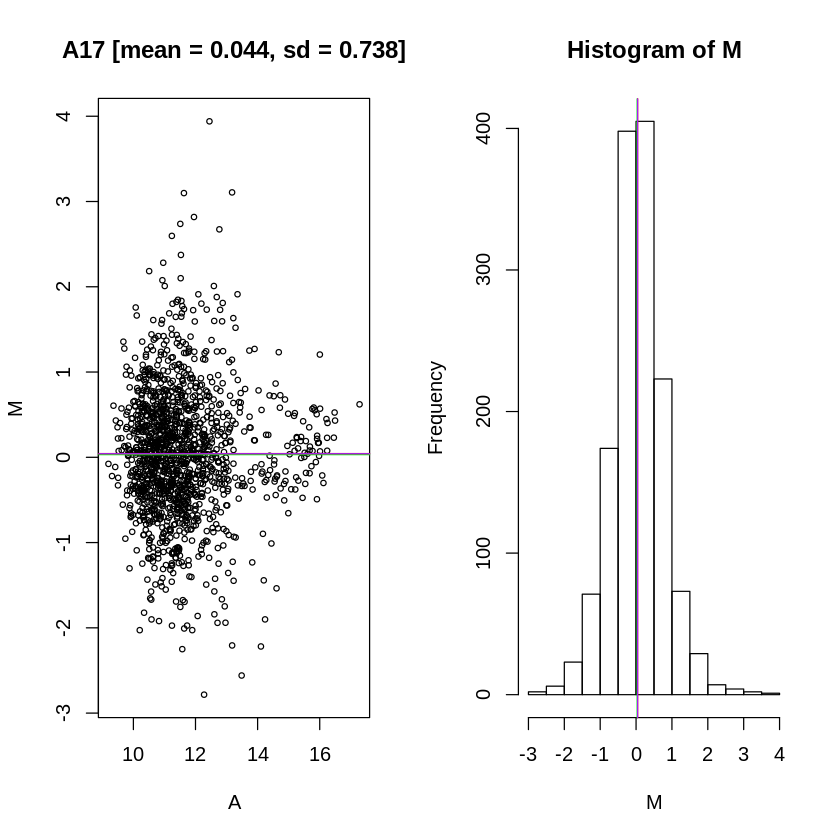

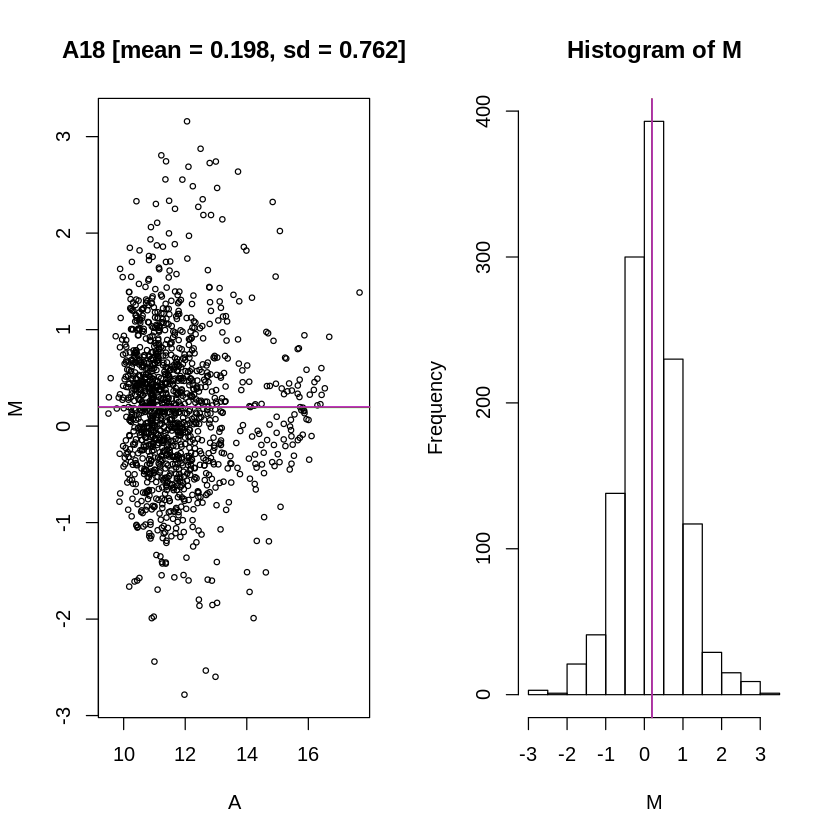

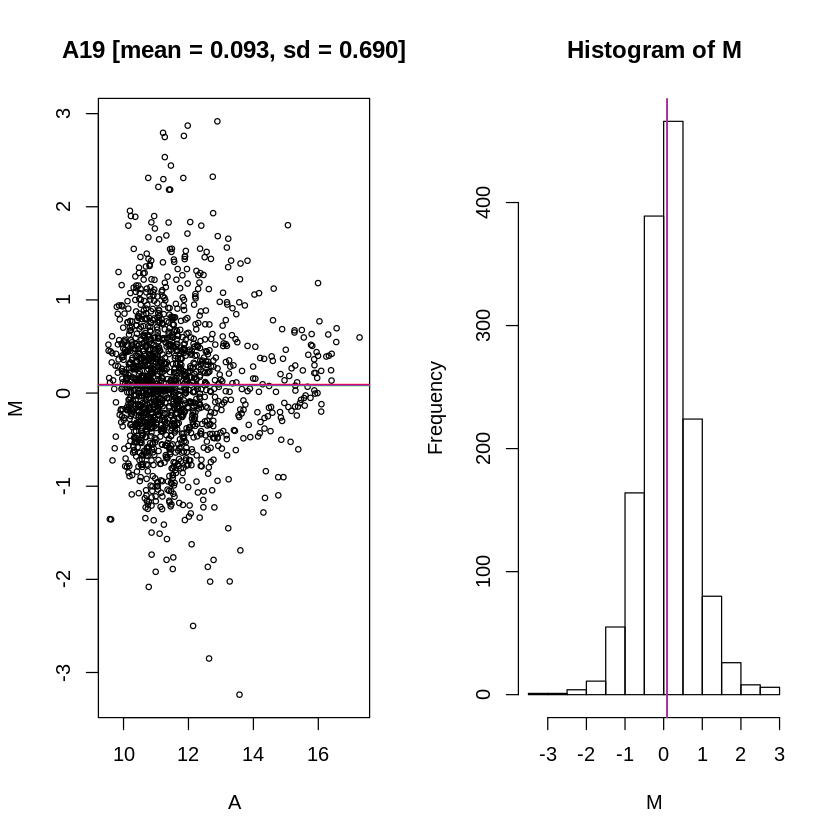

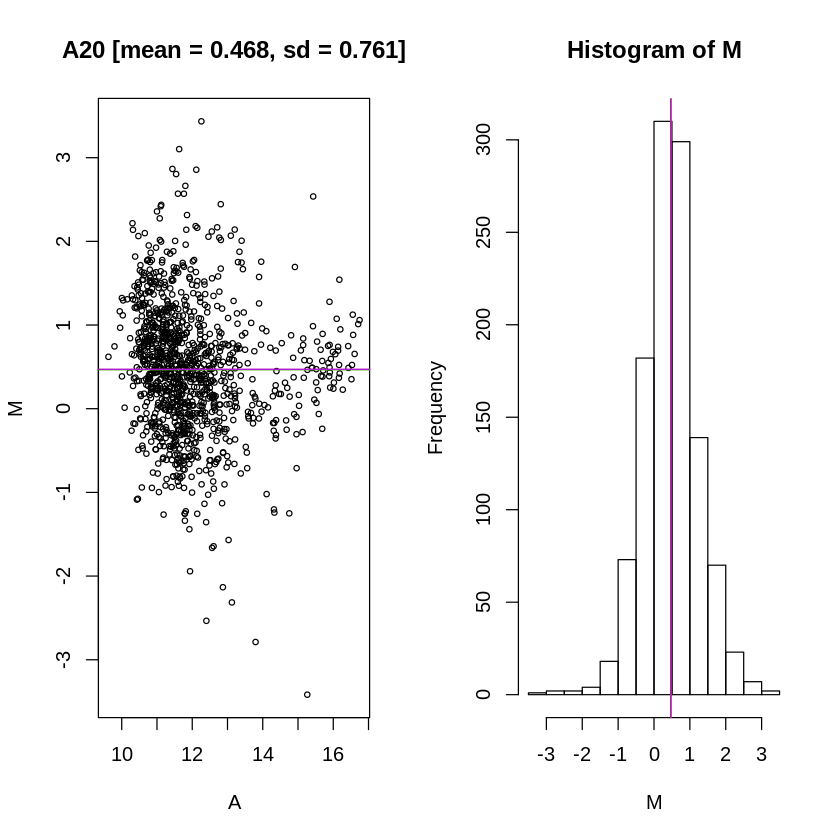

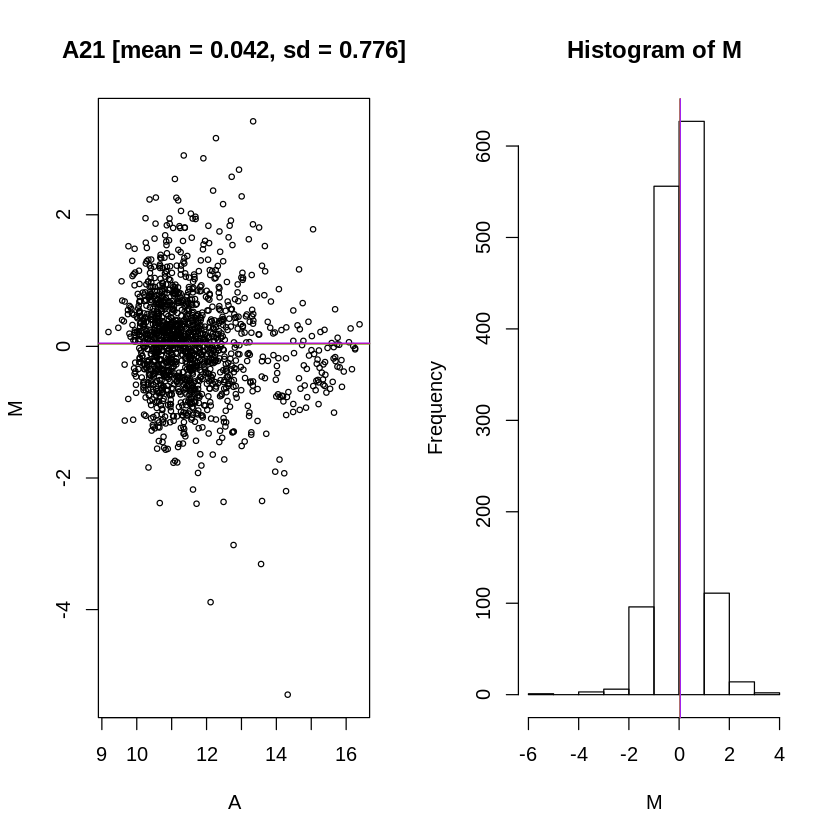

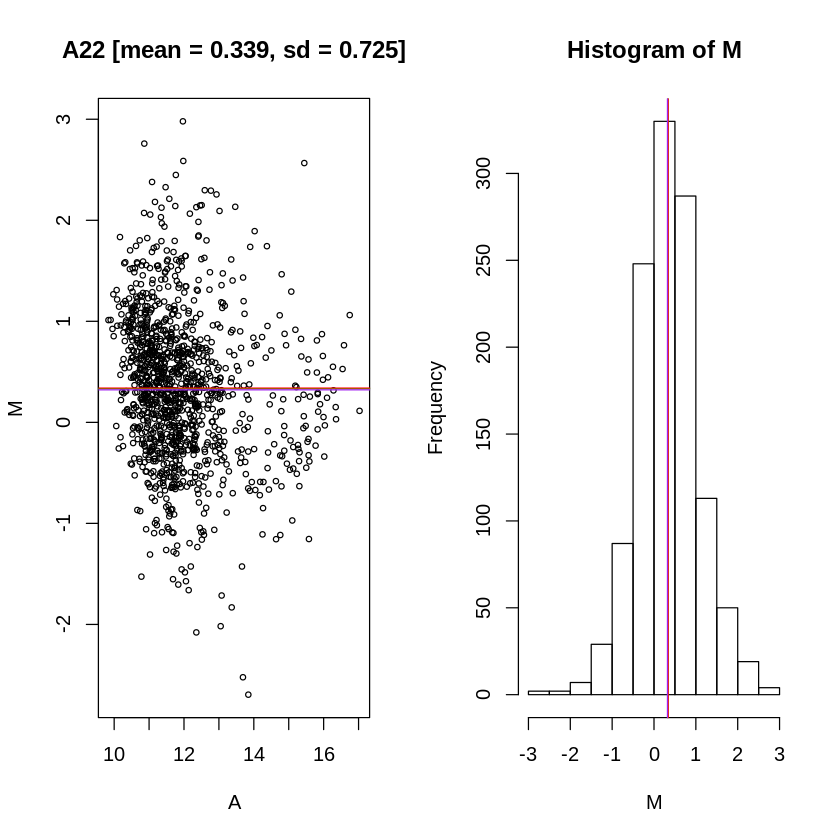

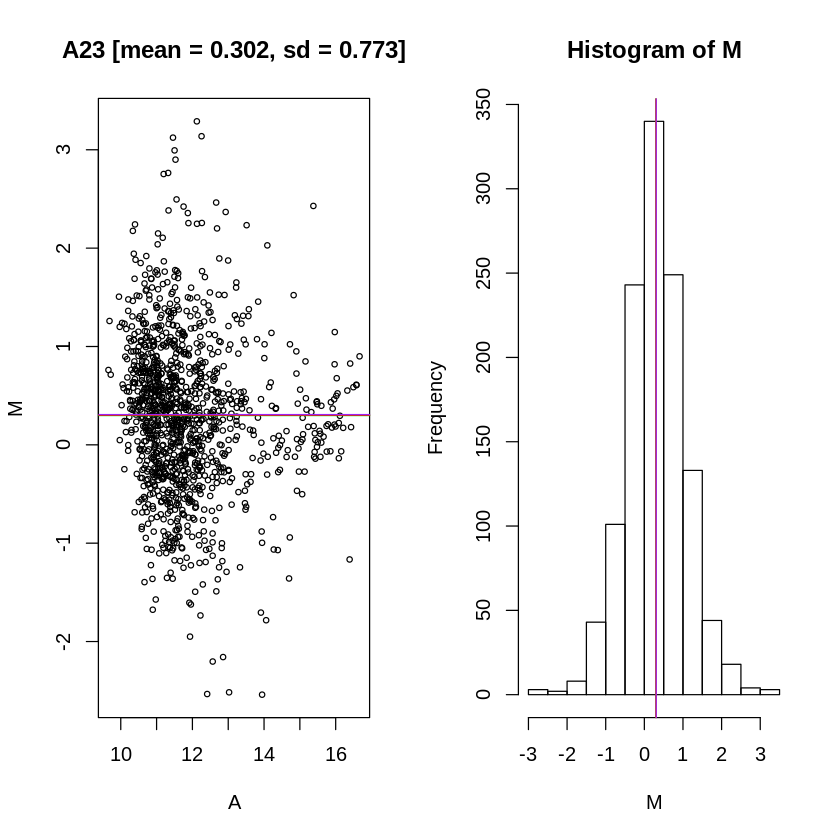

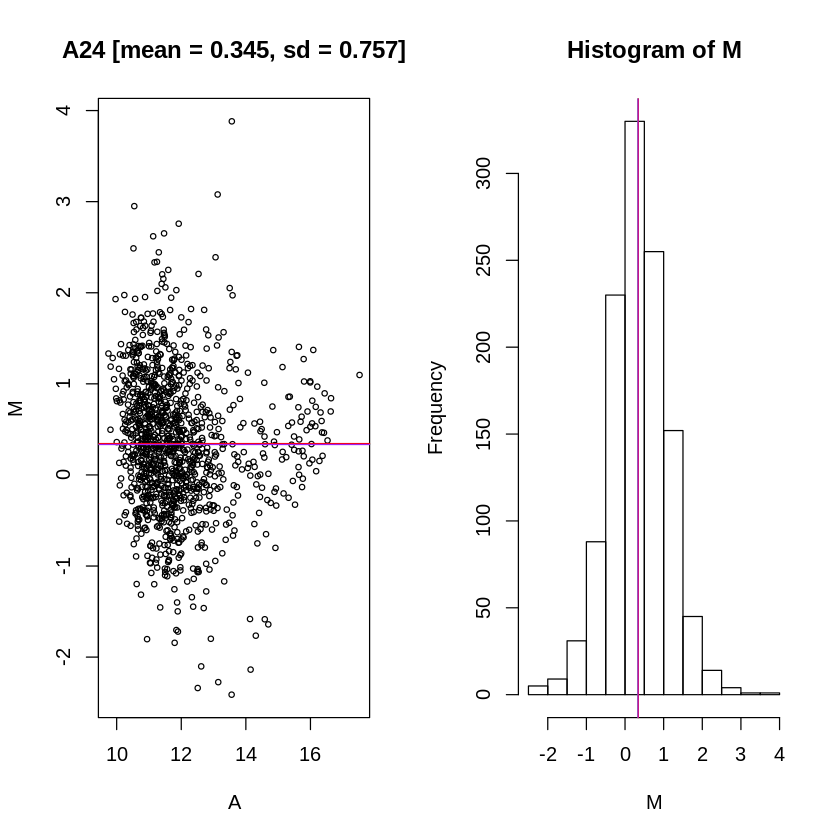

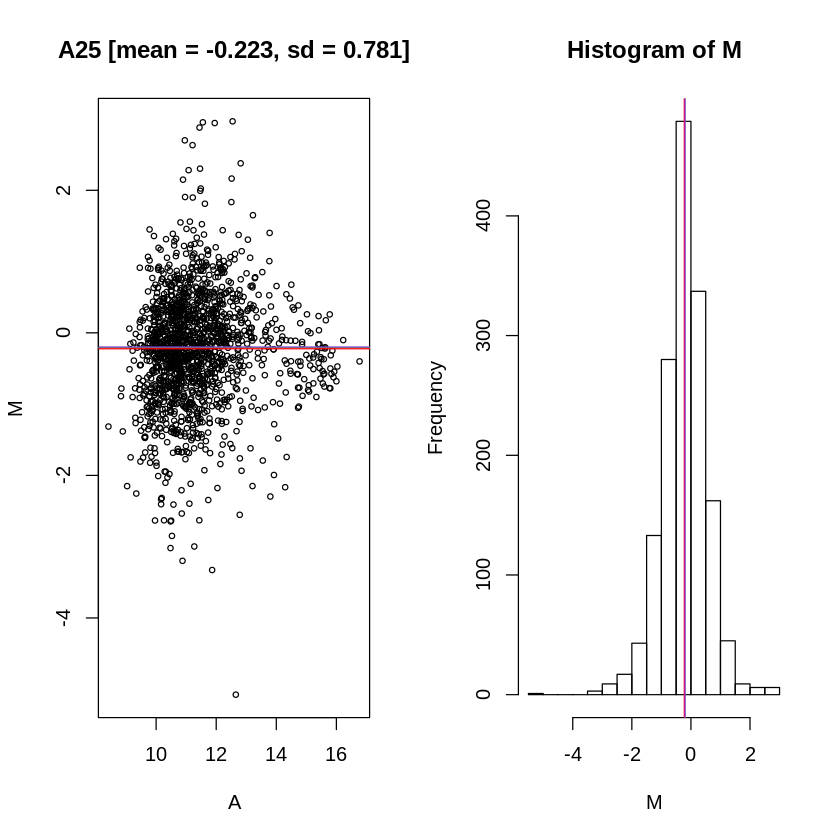

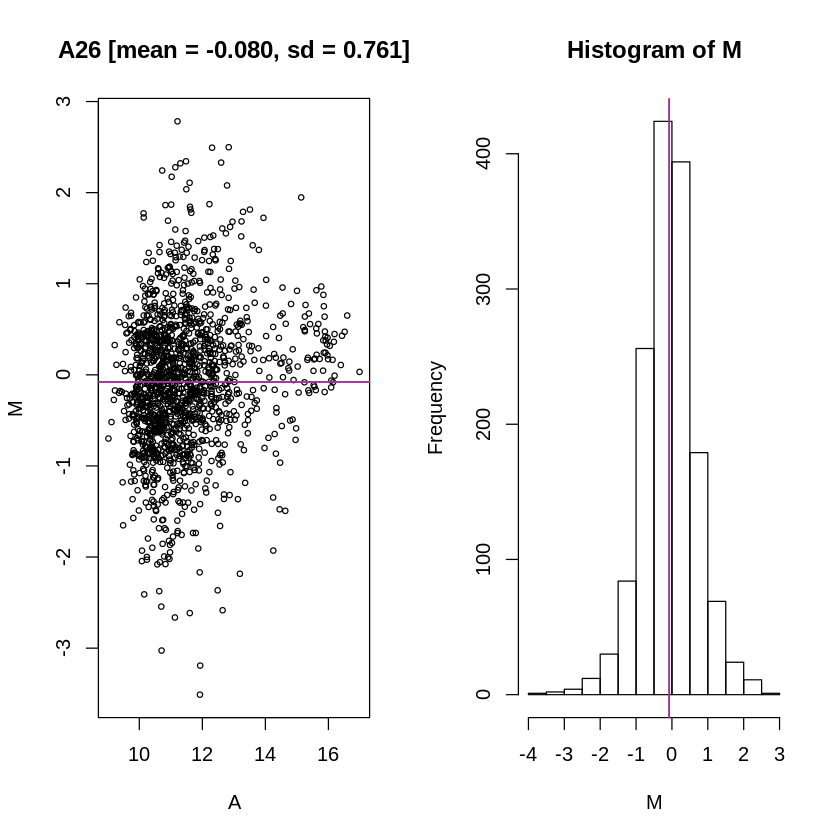

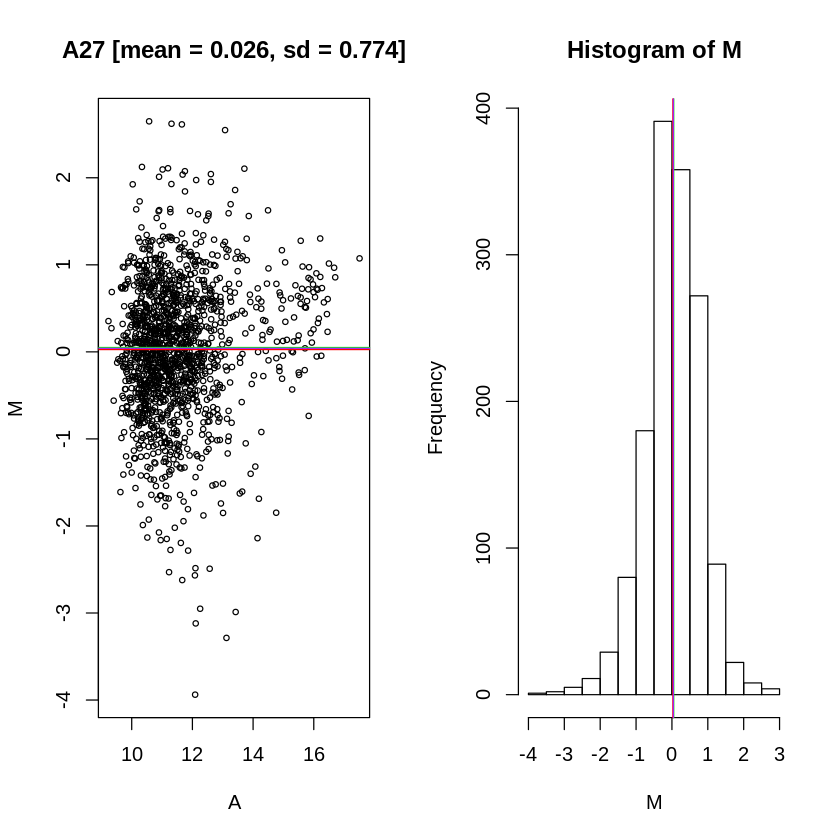

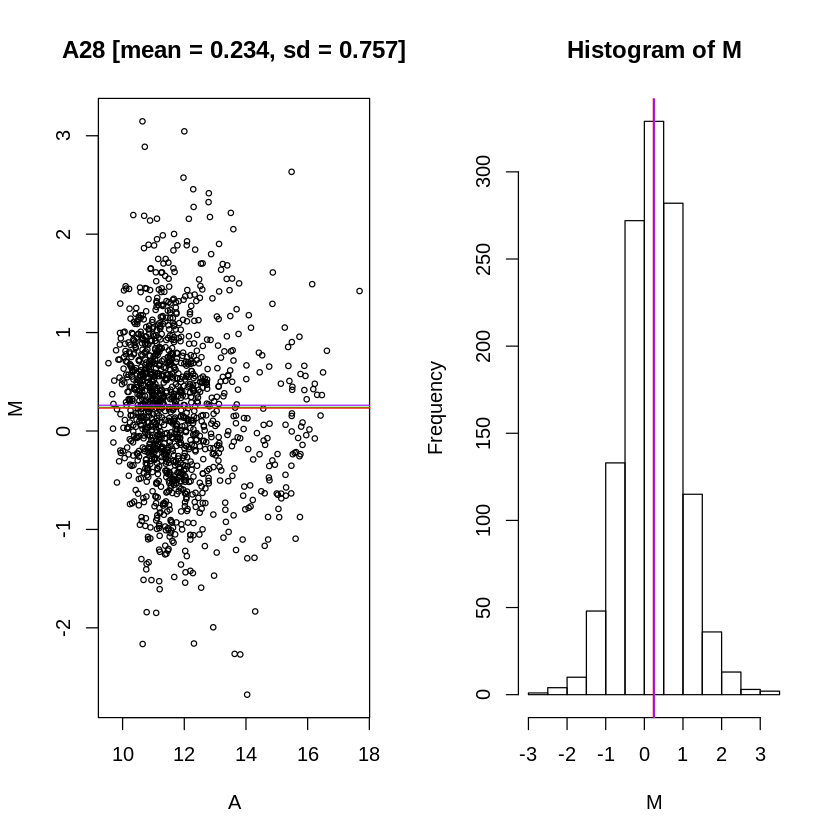

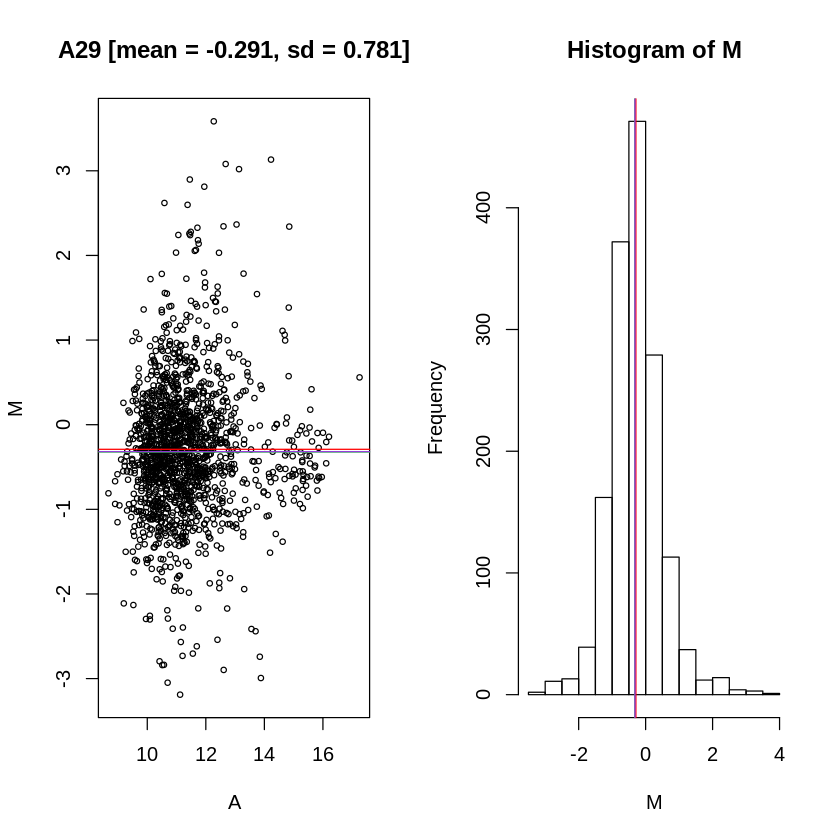

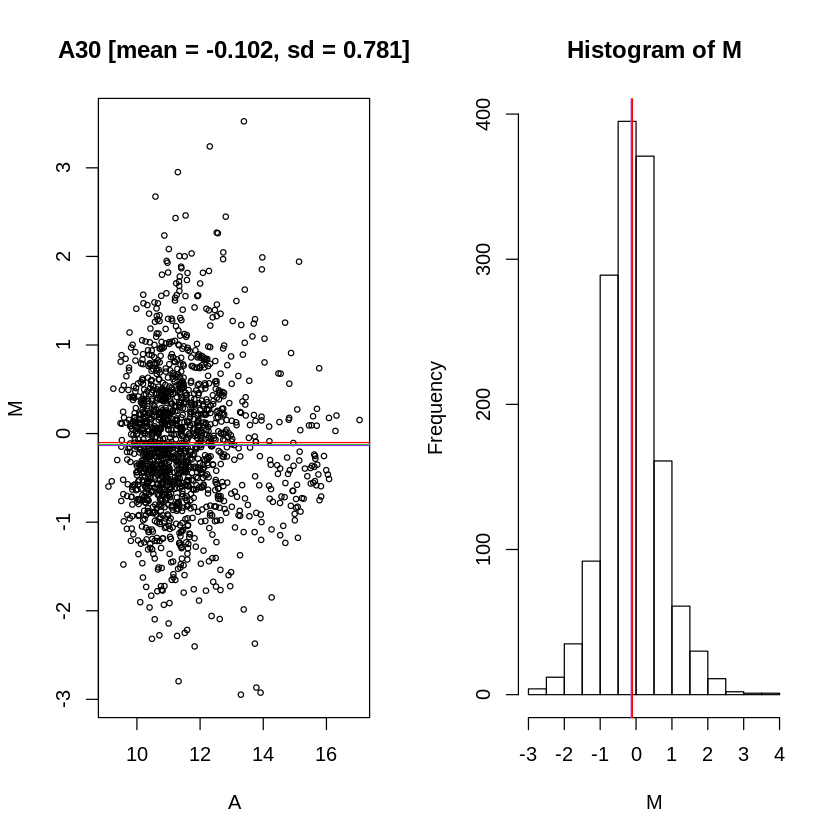

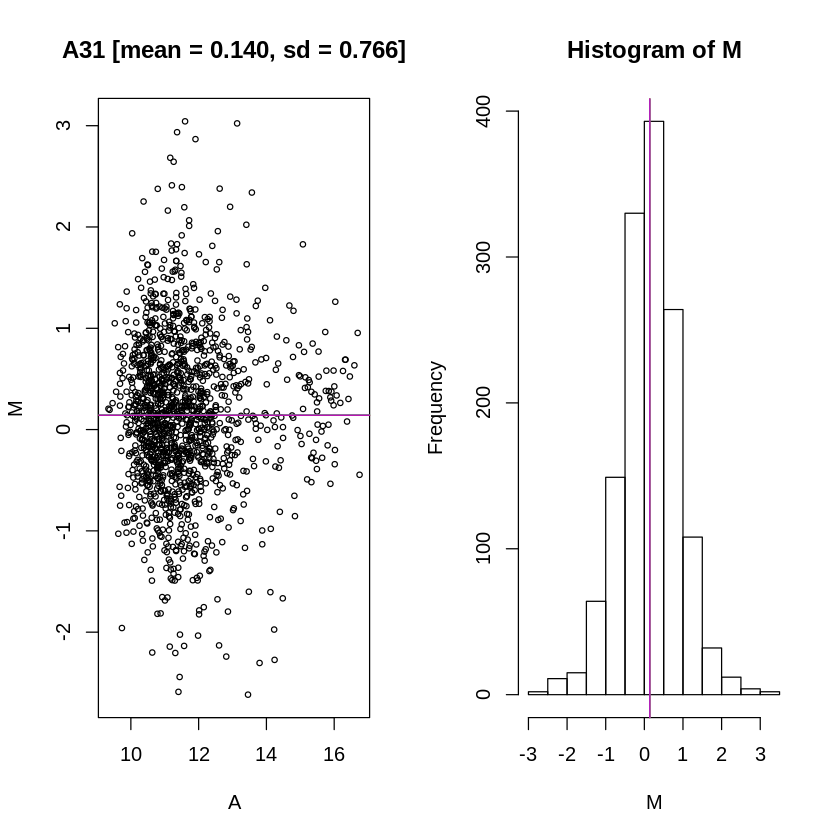

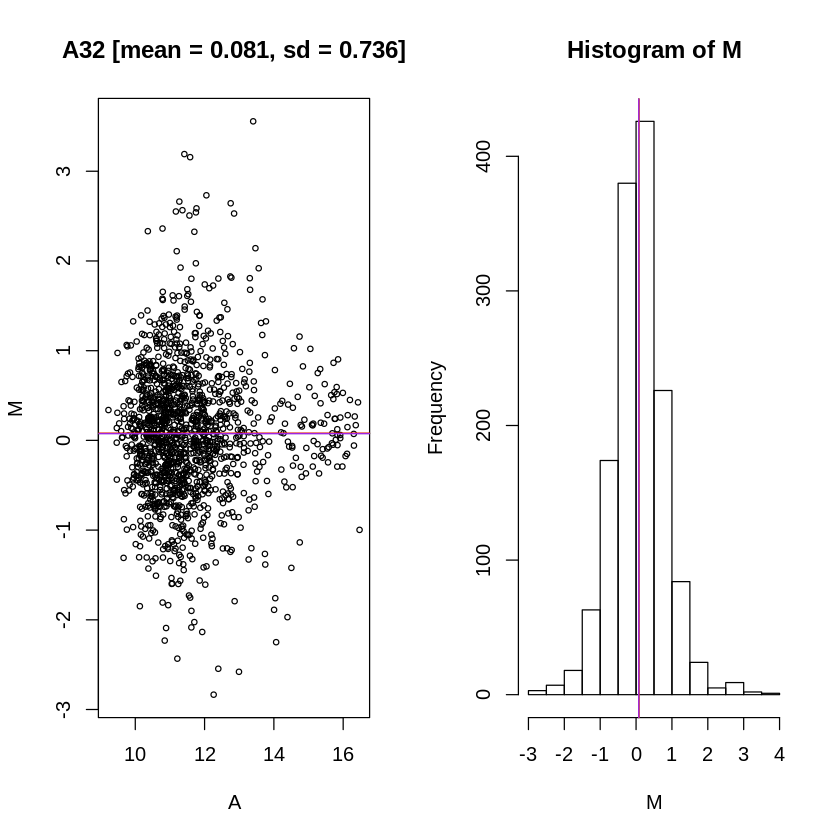

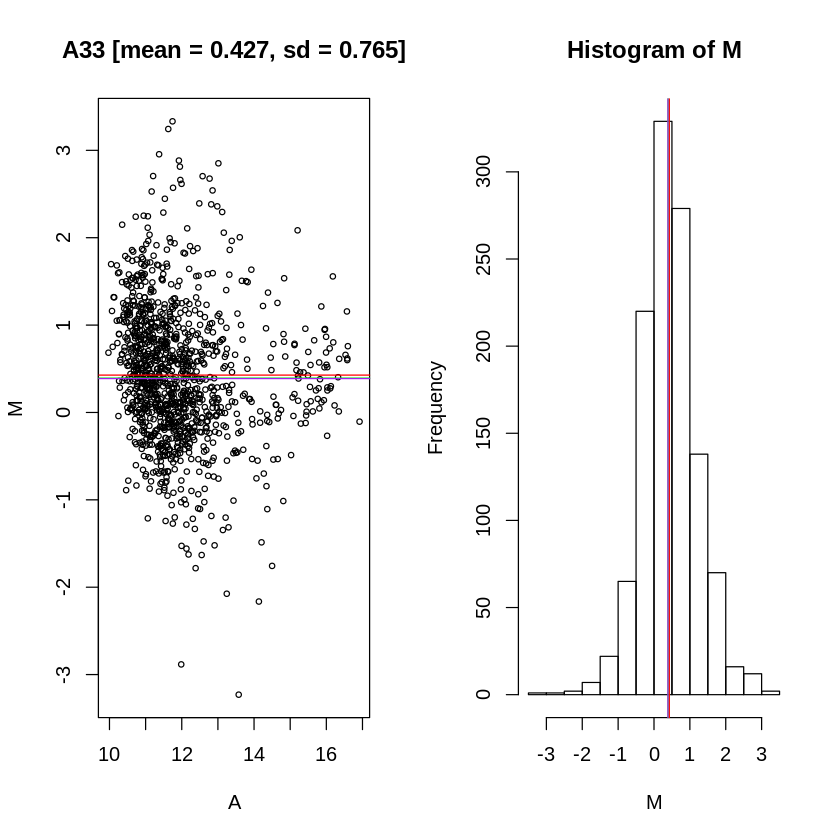

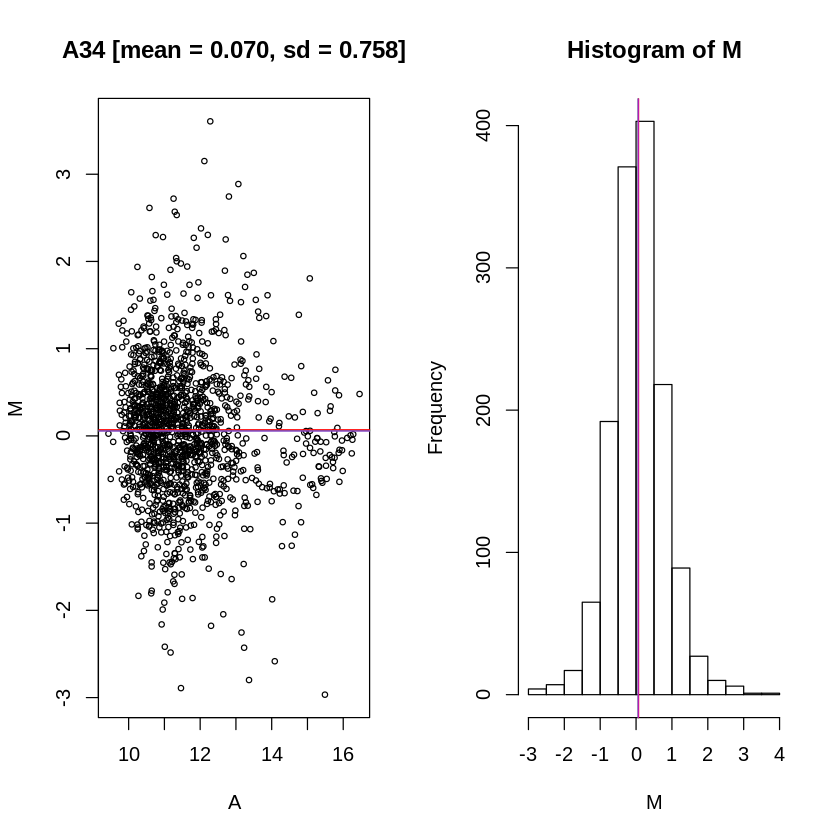

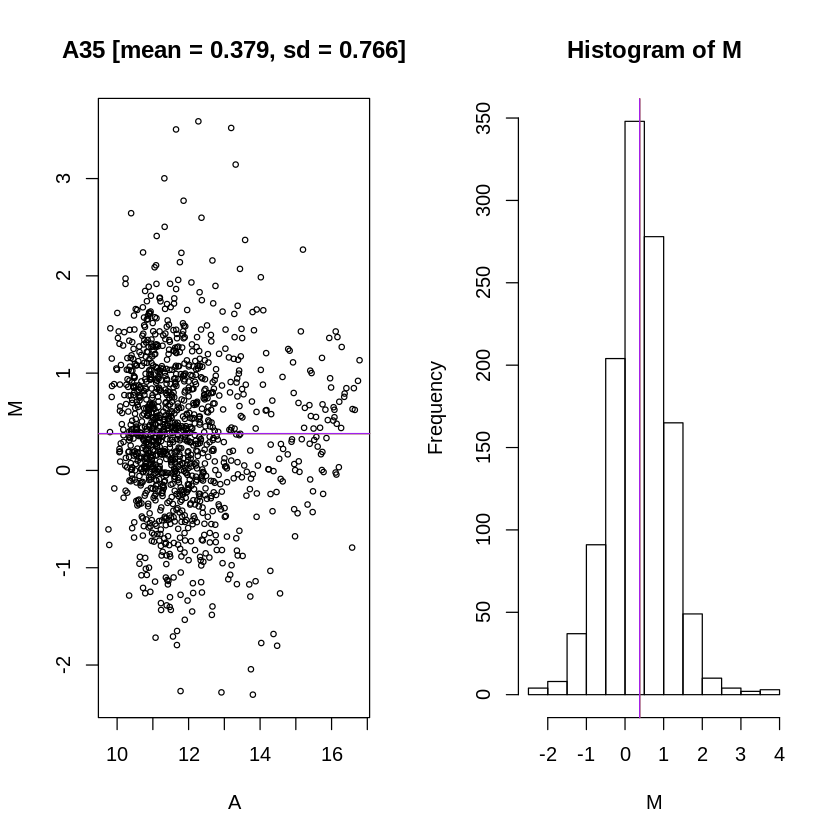

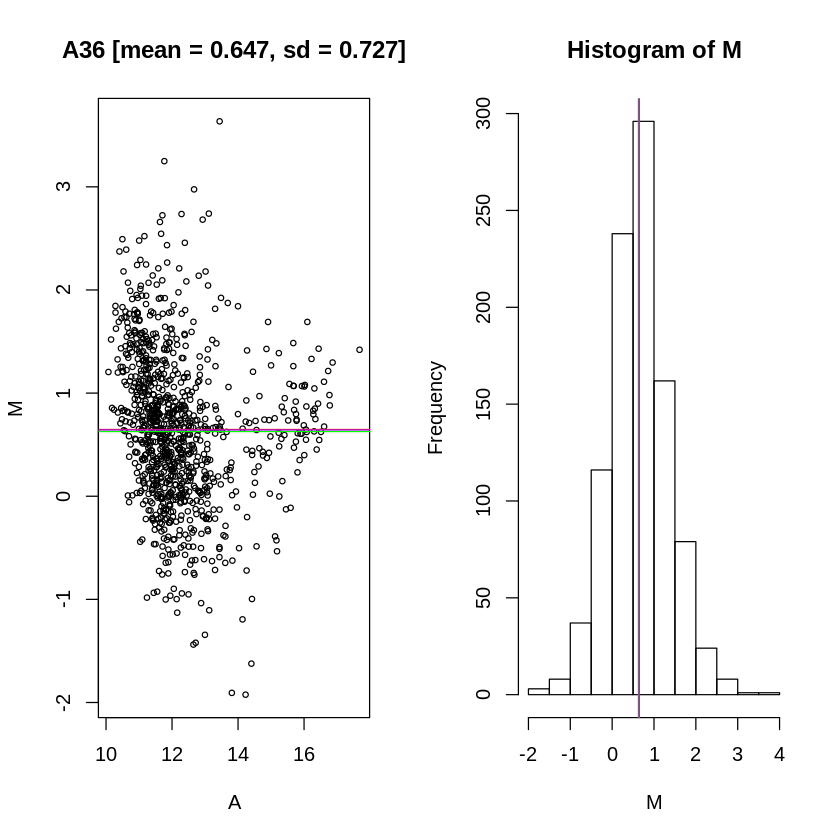

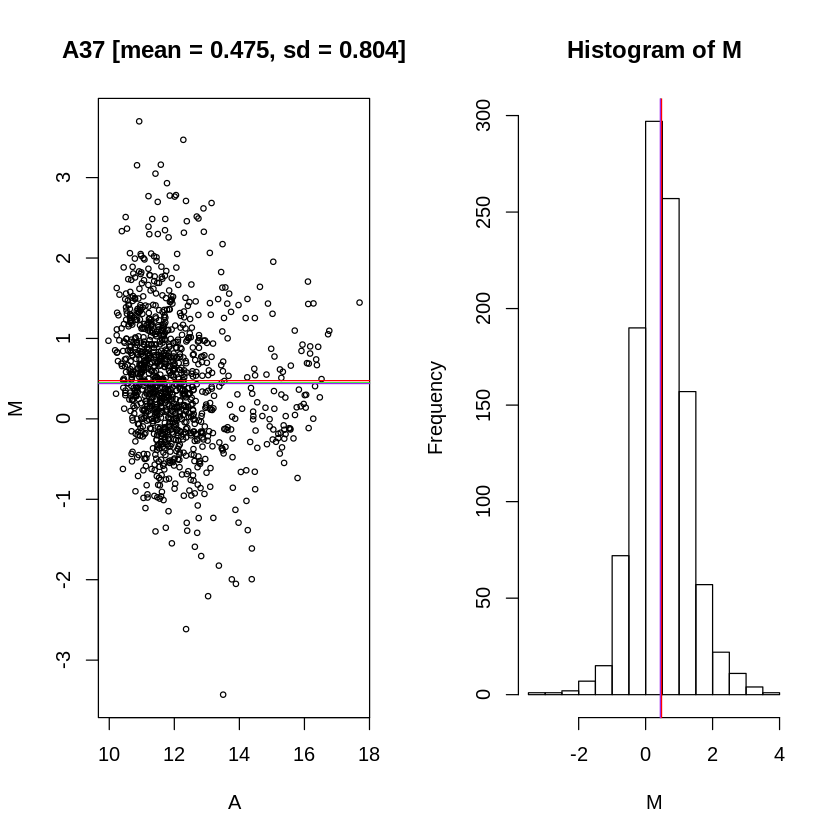

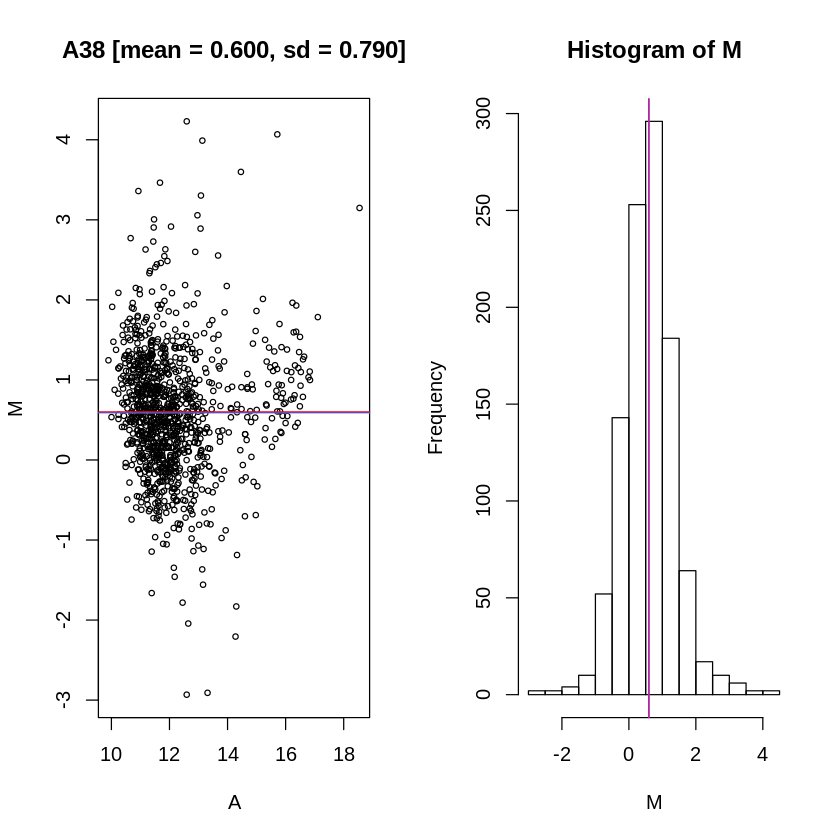

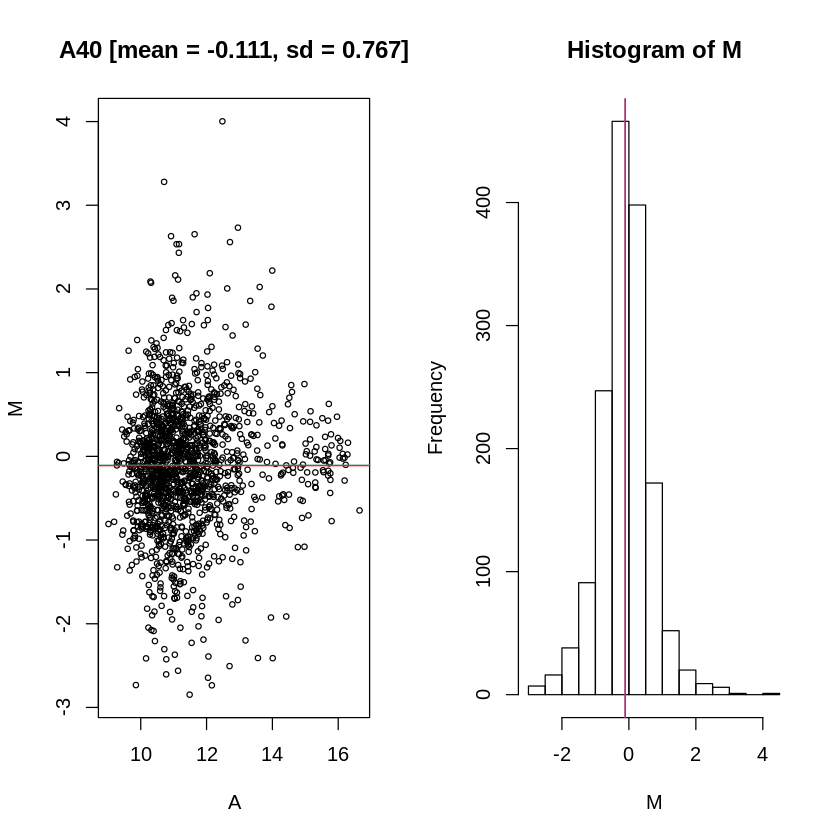

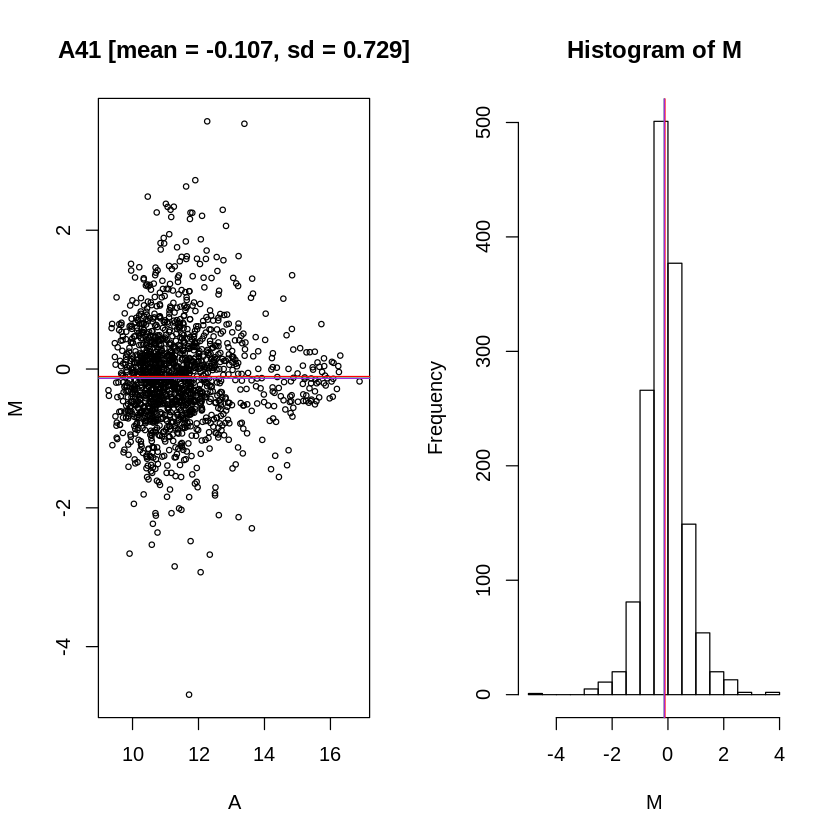

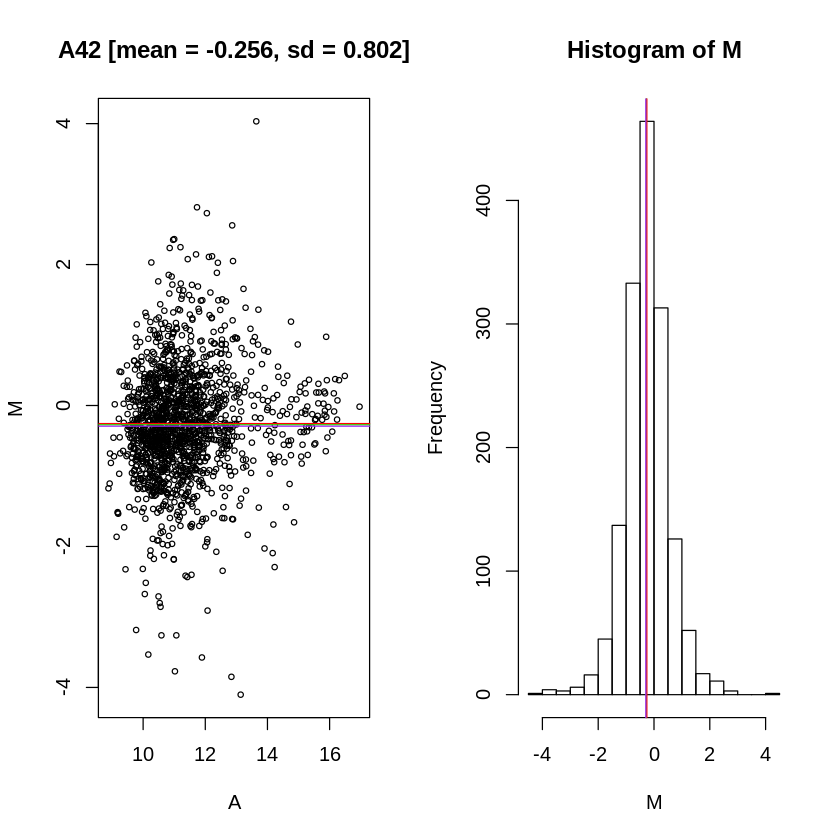

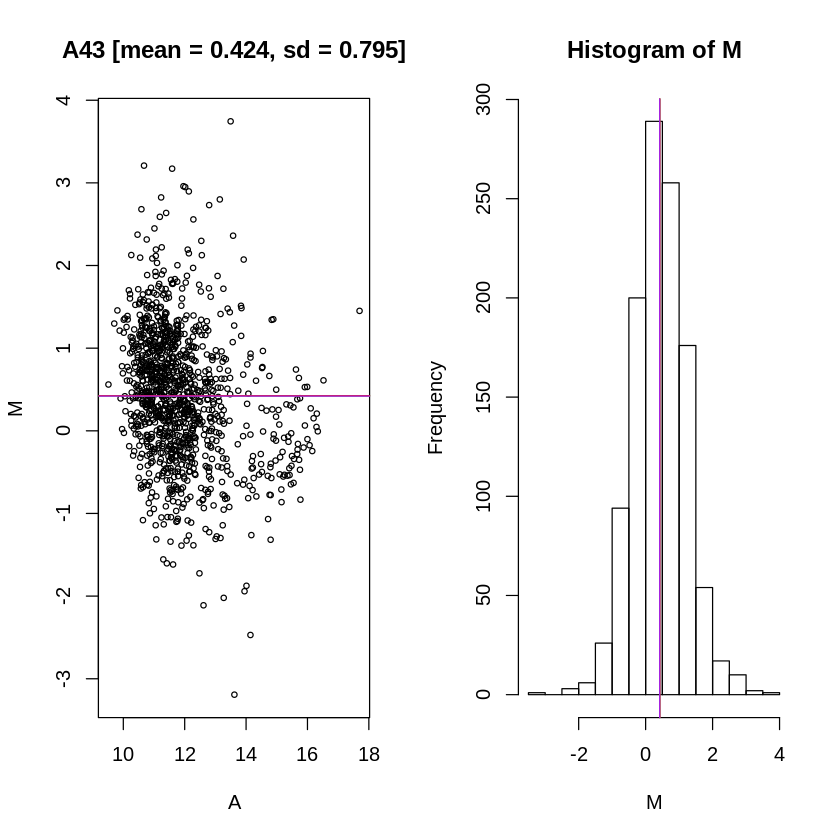

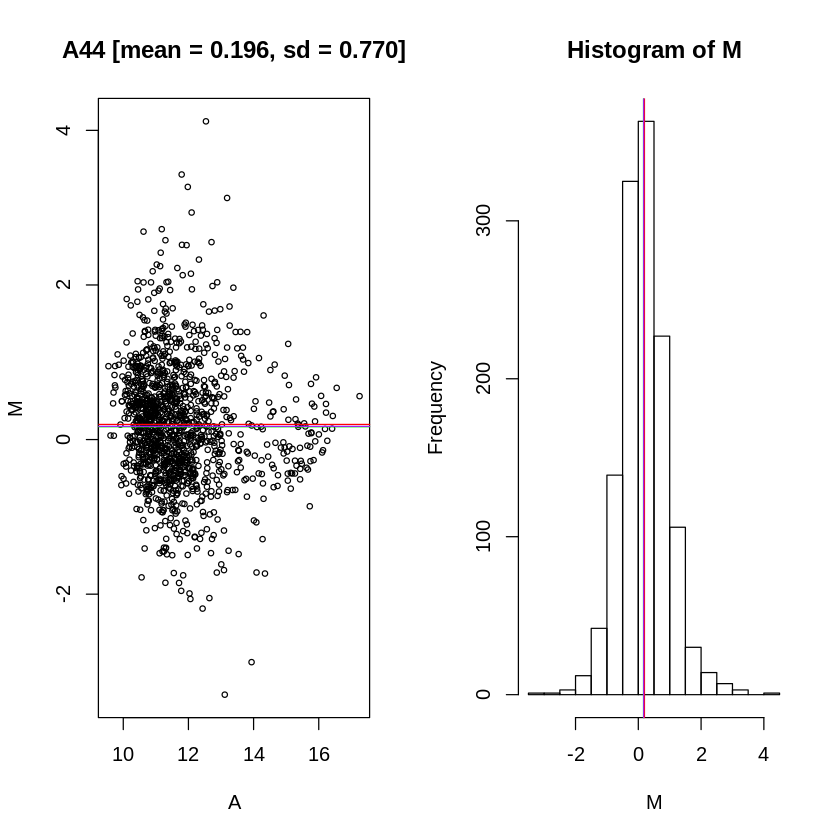

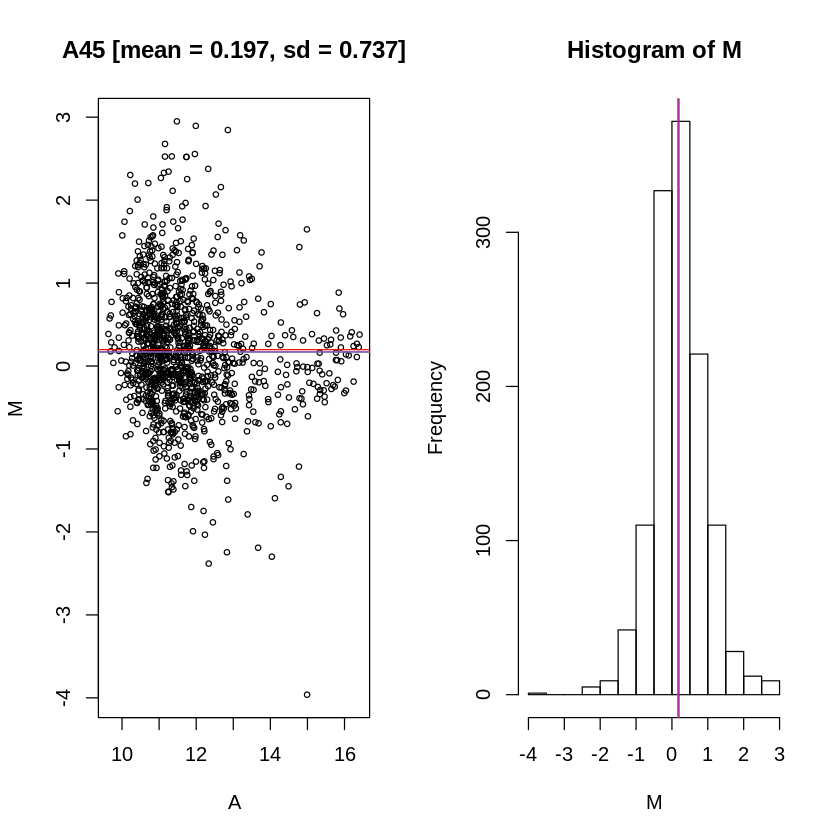

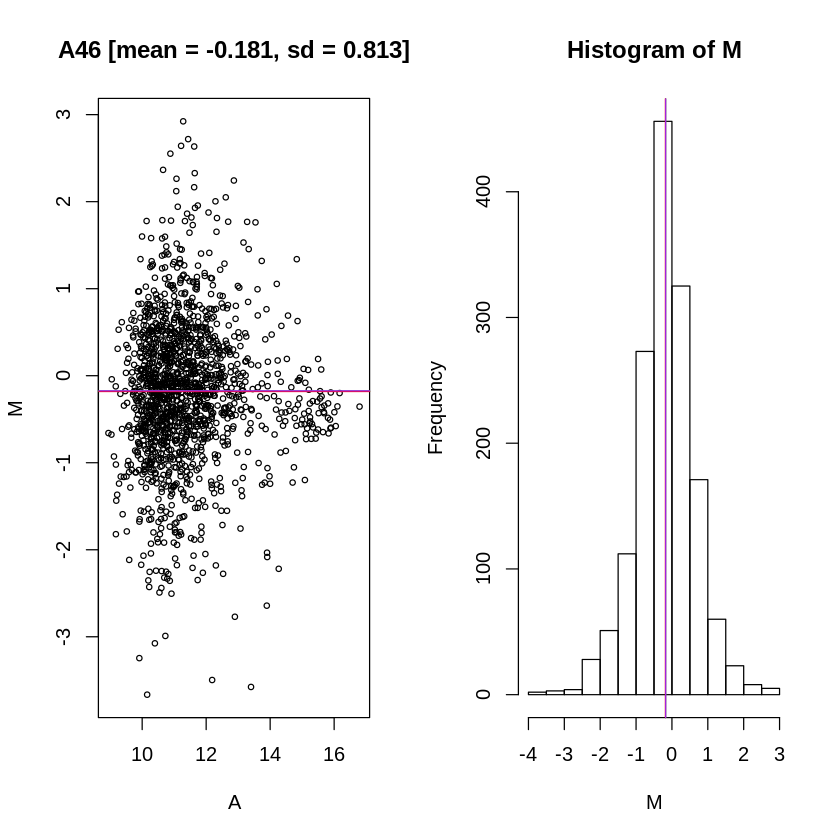

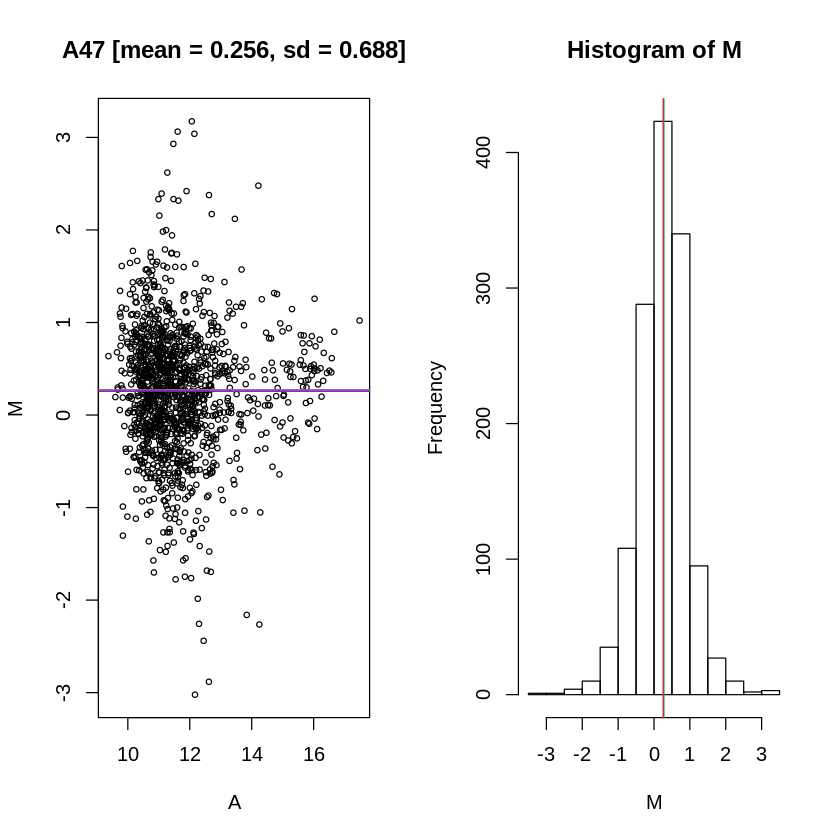

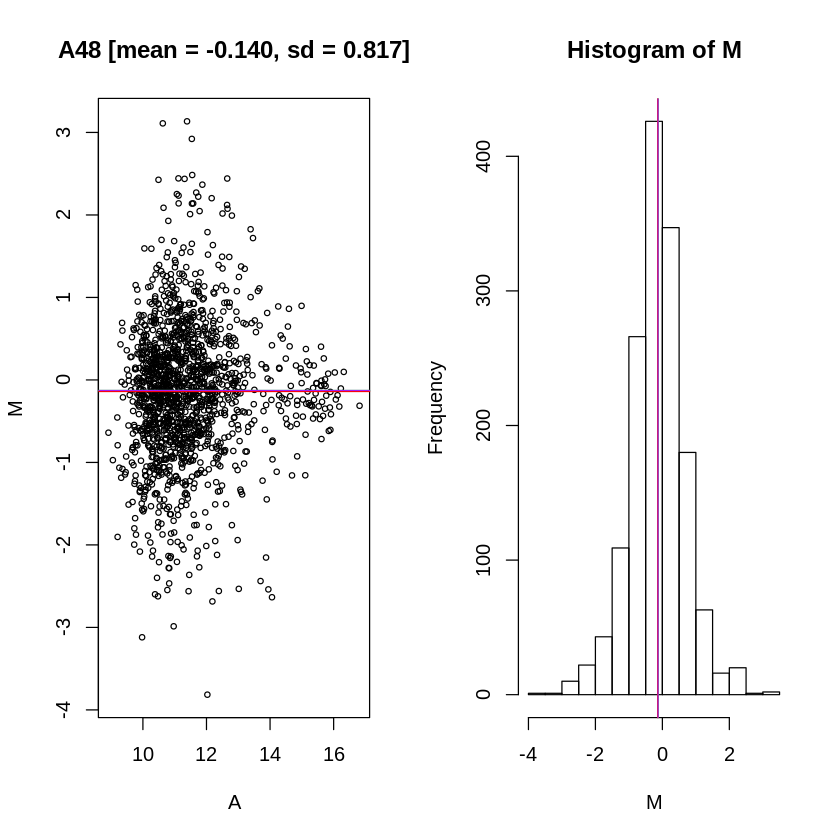

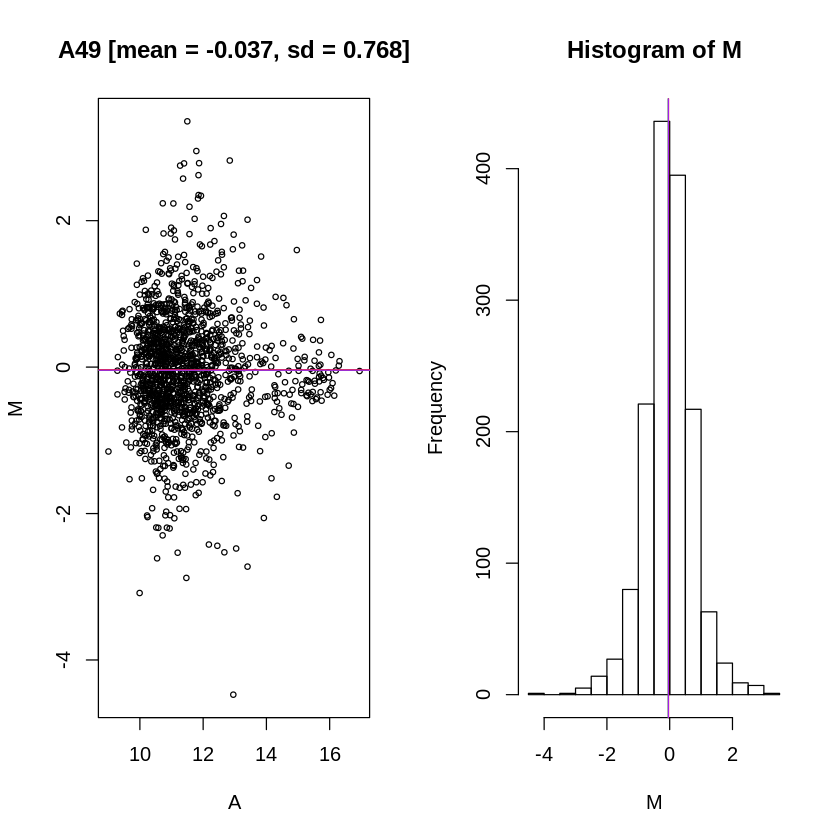

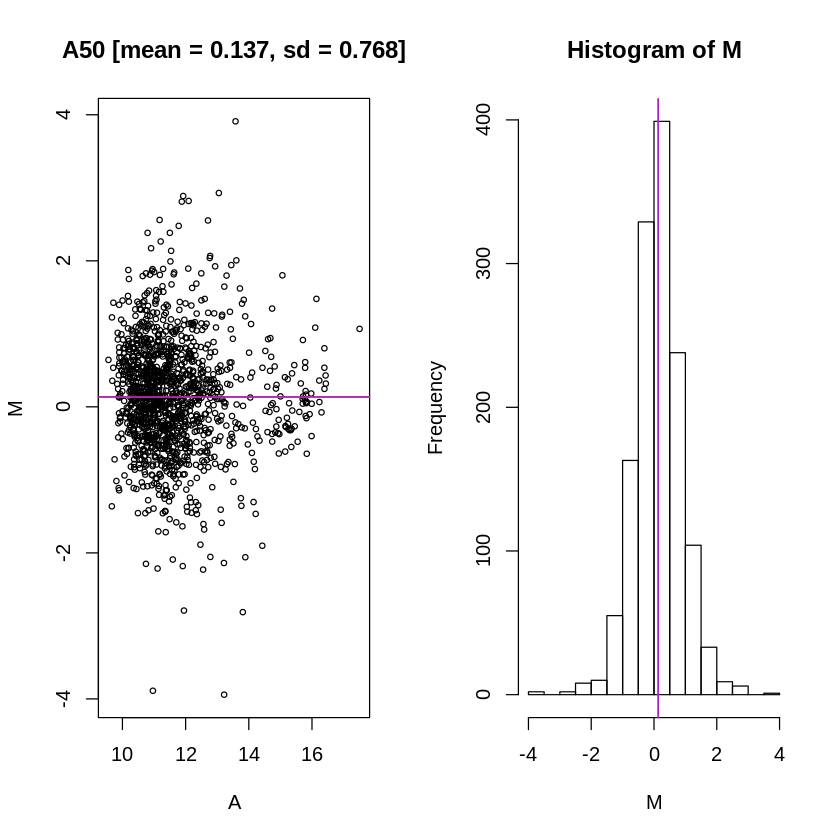

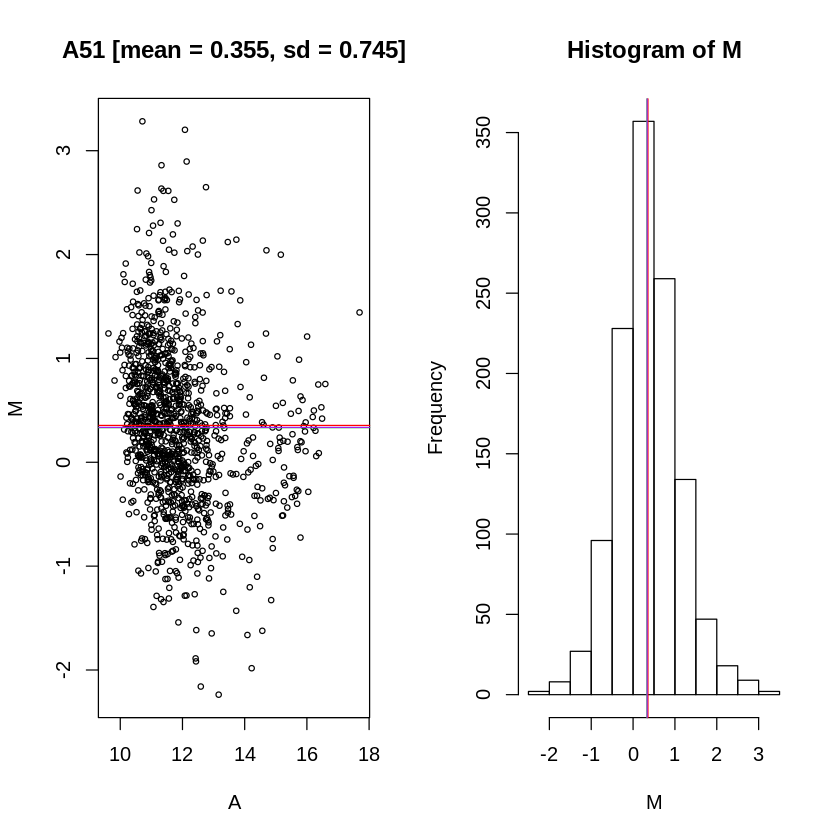

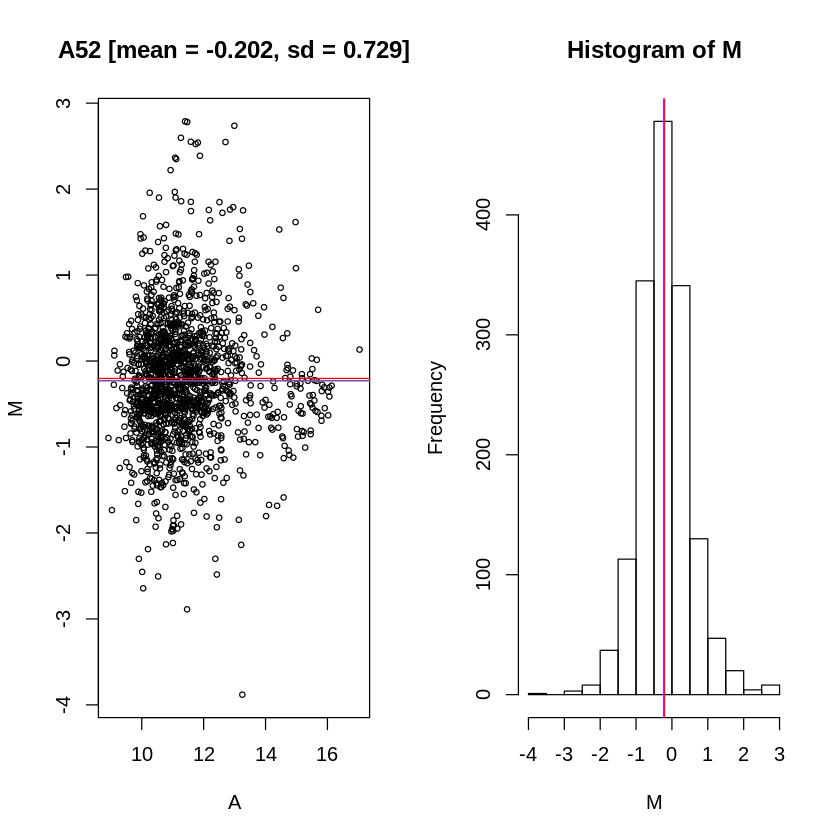

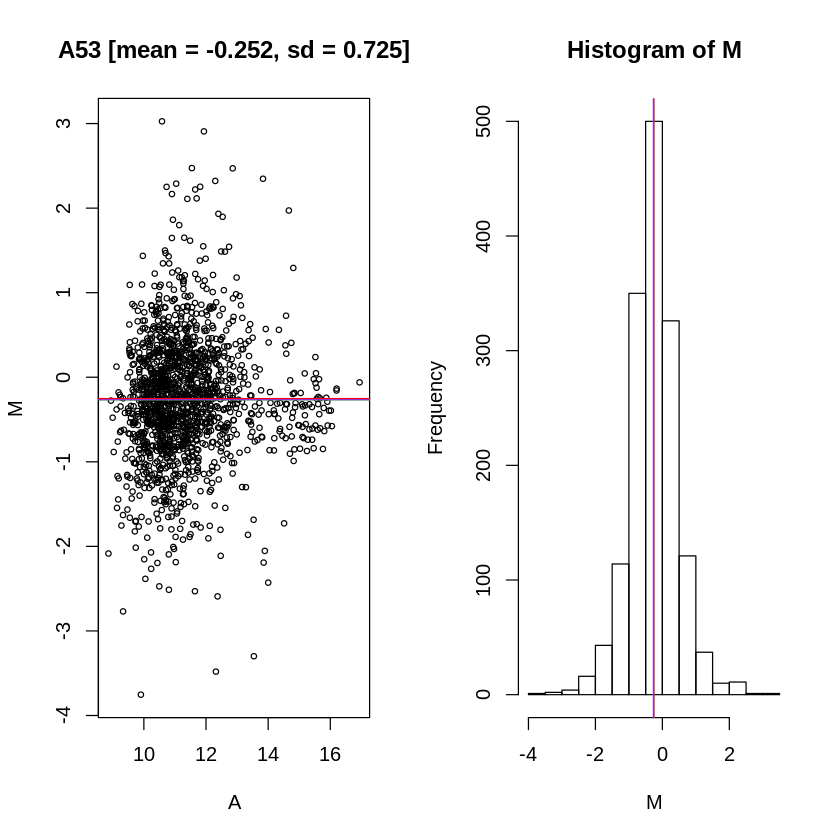

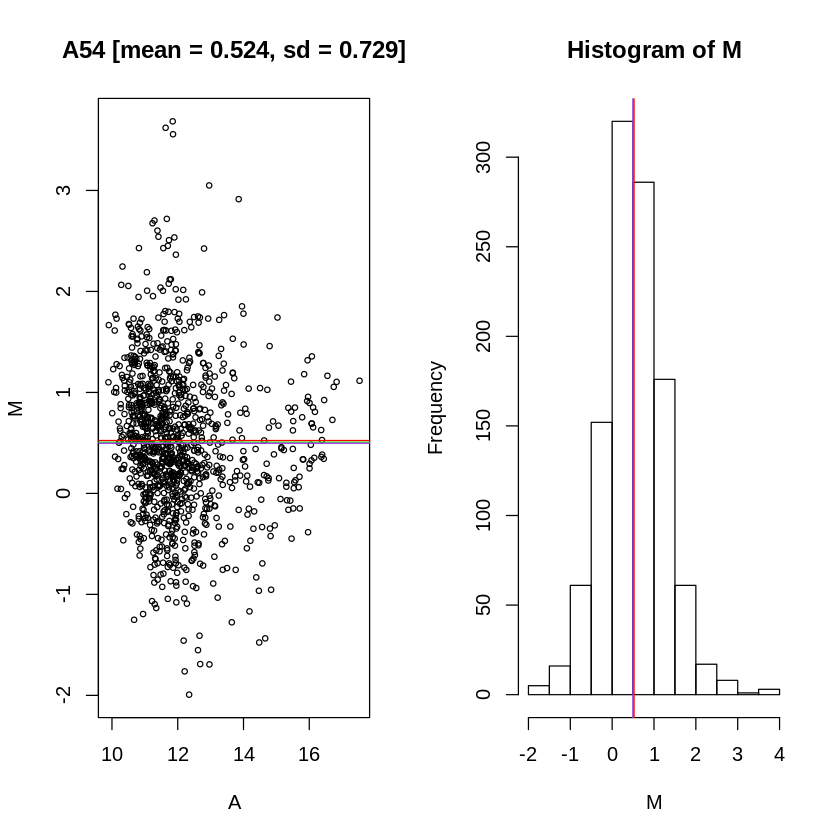

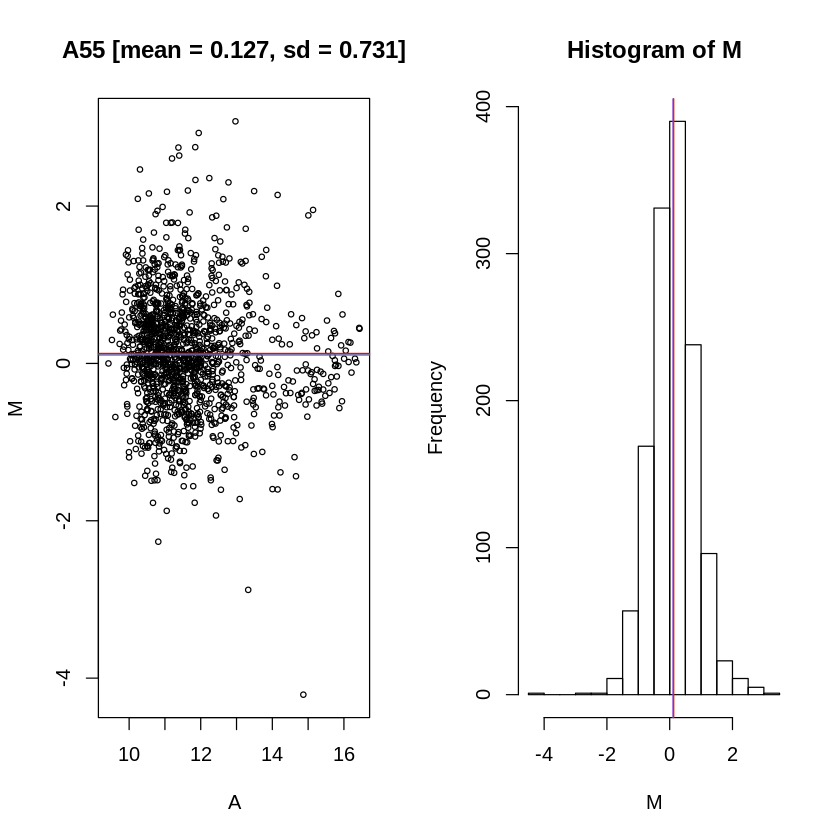

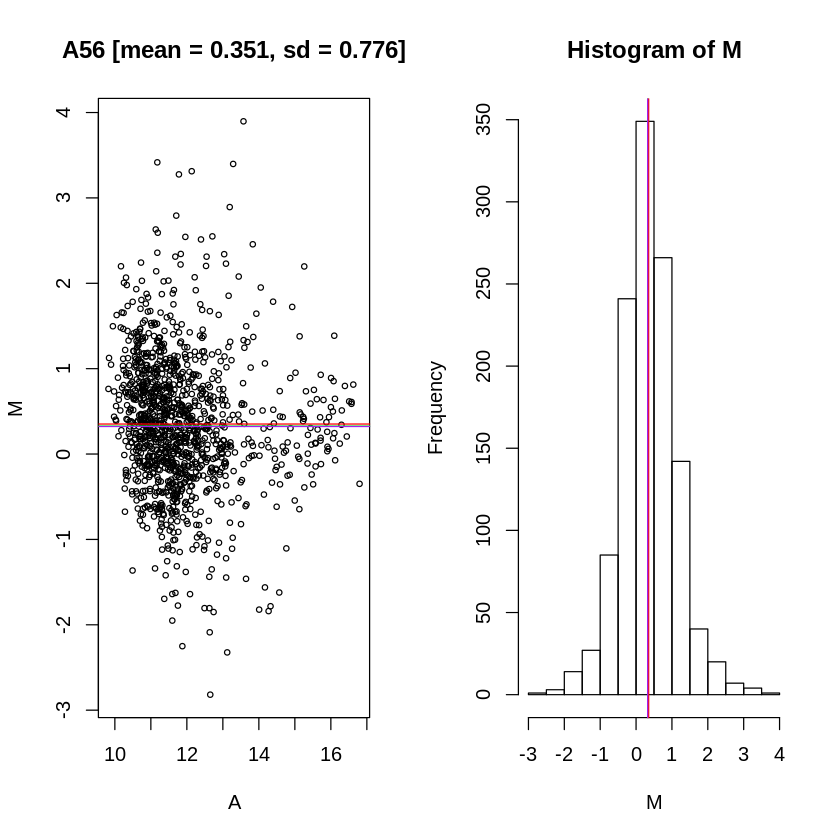

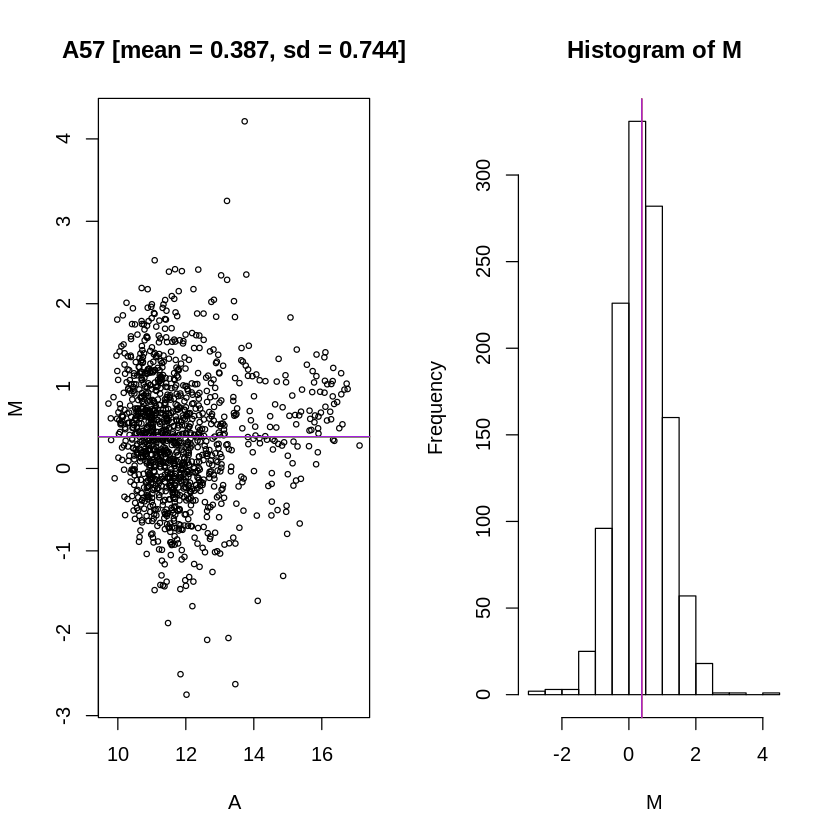

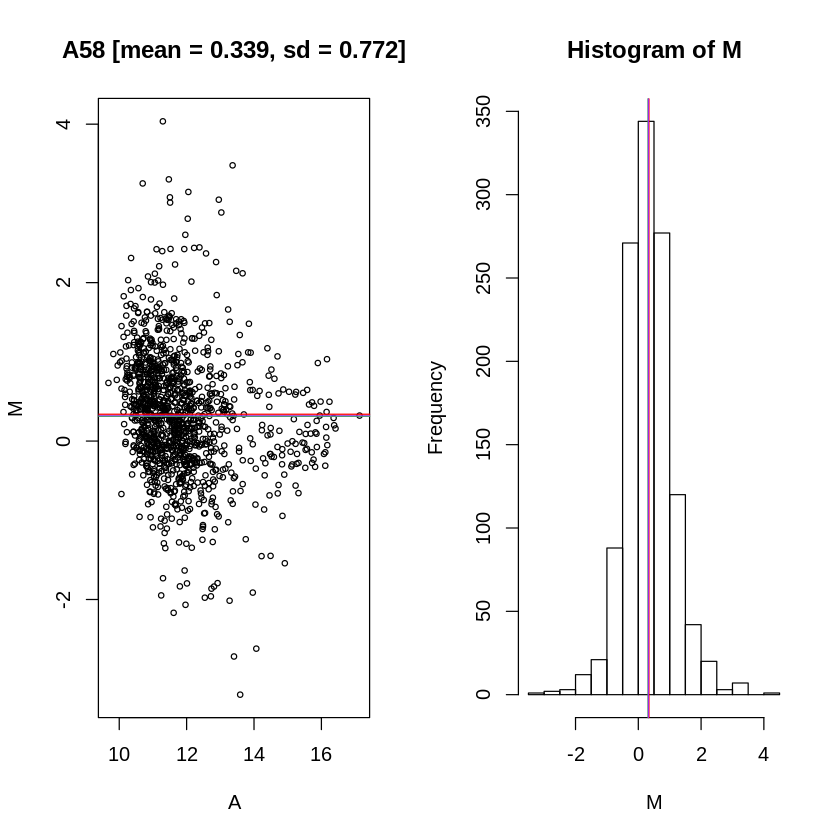

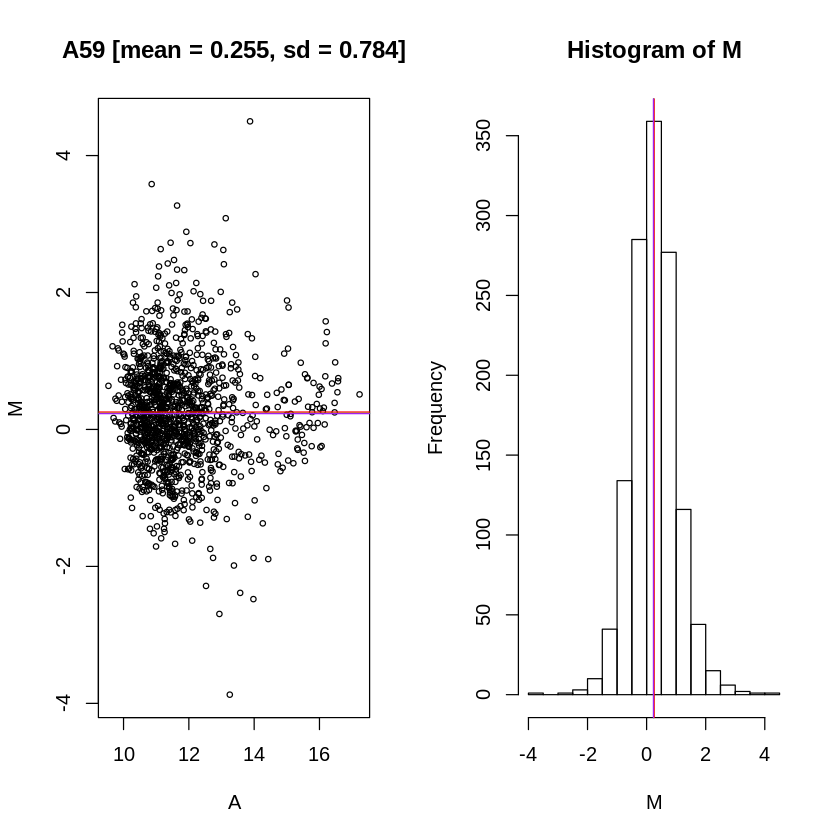

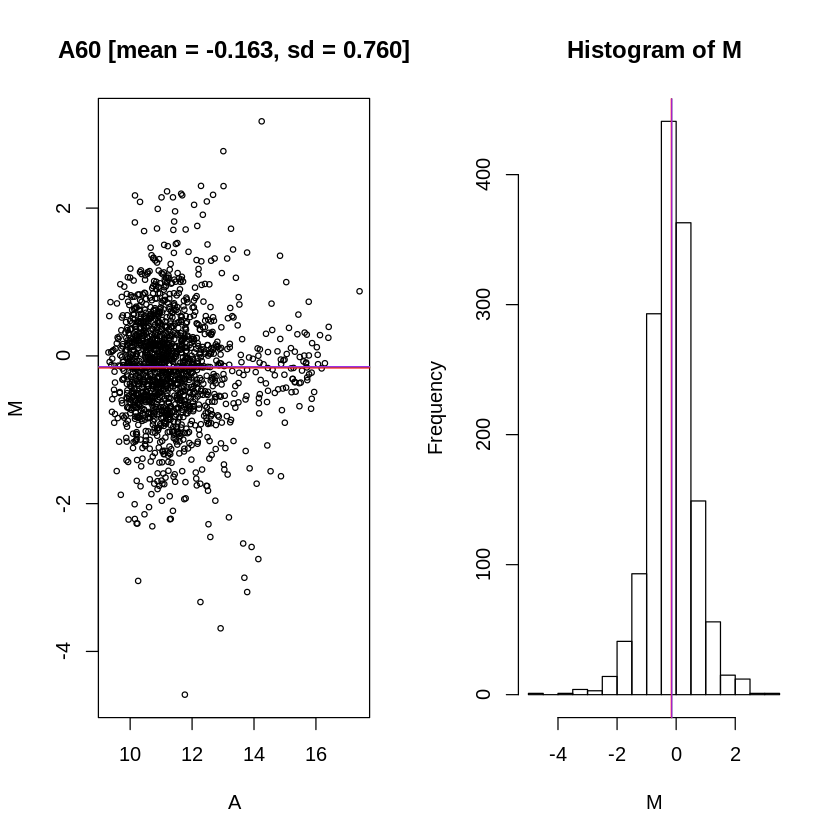

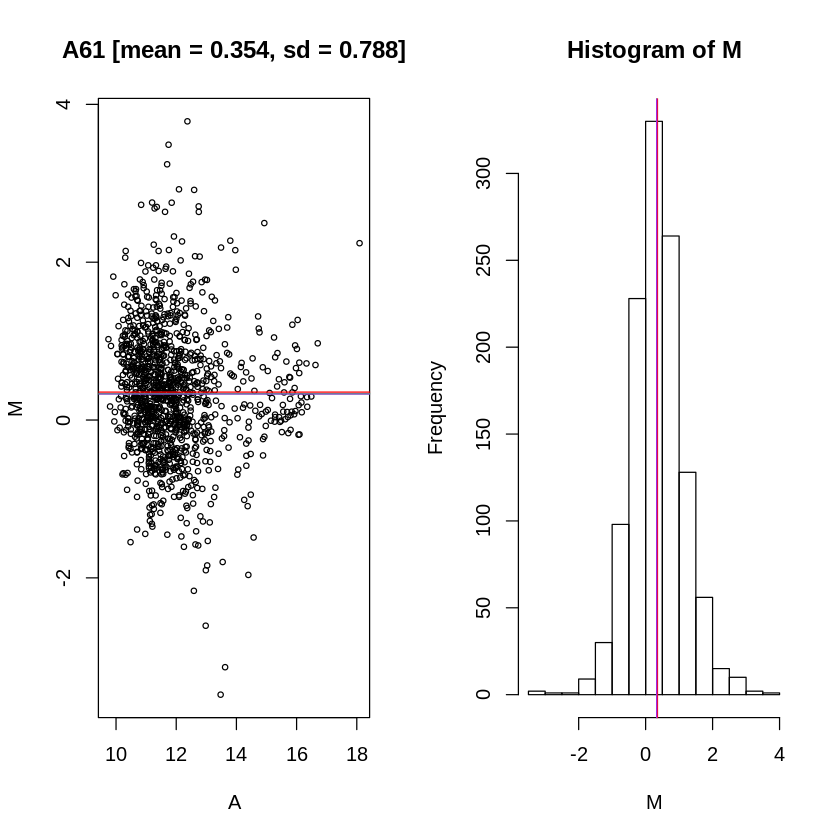

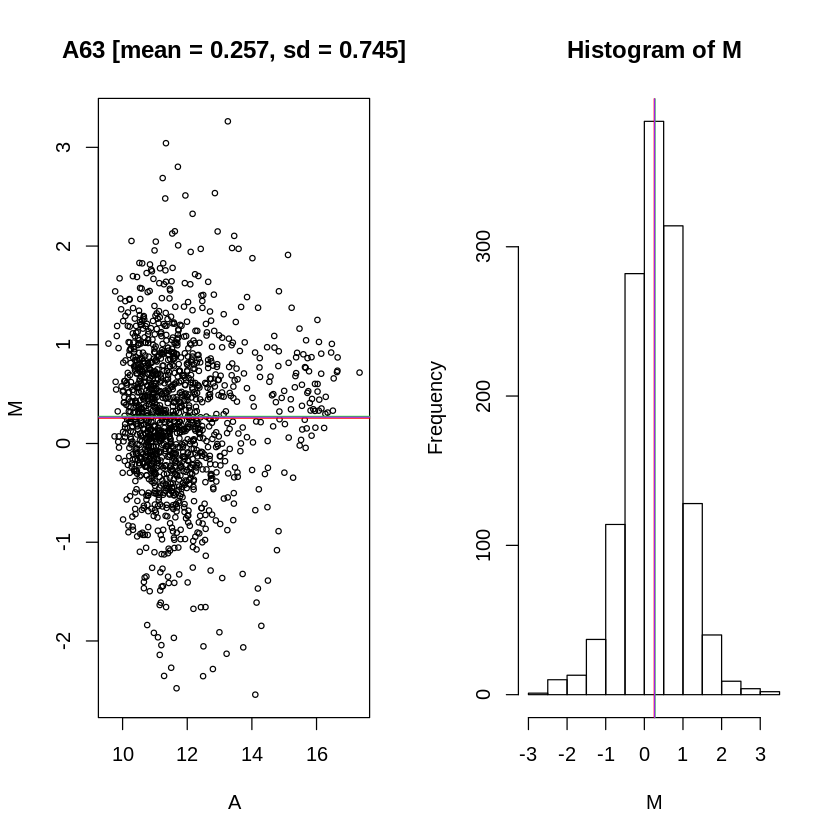

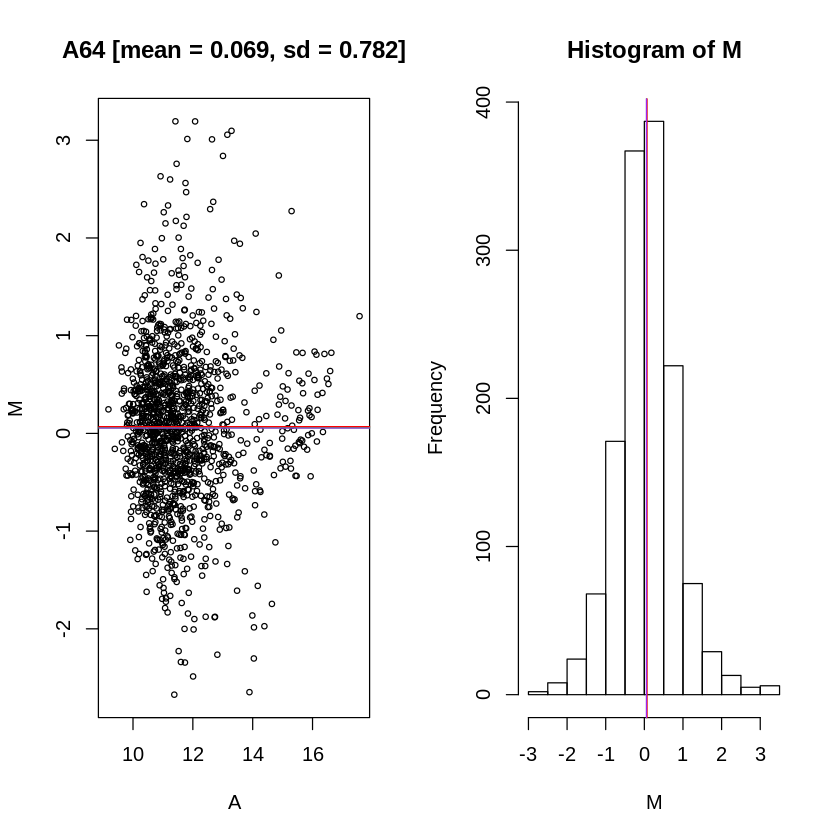

In [43]:
## Plot: All probeset intensities

for (pid in colnames(hyperdiploid1)) {
  # wpath <- sprintf("~/Dropbox/temp/ma_plot/%s_N01.pdf", pid)
  # pdf(wpath, width = 10, height = 5)
  plot_ma(hyperdiploid1[,pid], normal1$N14, title = pid)
  # dev.off()  
}

In [ ]:
# for (pid in colnames(hypall_norm)[1:76]) {  
#   wpath <- sprintf("~/Dropbox/temp/ma_plot/%s_N01.pdf", pid)
#   pdf(wpath, width = 10, height = 5)
#   plot_ma(hypall_norm[,pid],
#           hypall_norm[,"N01"],
#           title = sprintf("%s", pid))
#   dev.off()
# }



In [ ]:
# # Batch effects
# plot_ma(hypall_norm$P100_D0, hypall_norm$N01)
# # Technical variation
# plot_ma(hypall_norm$N02, hypall_norm$N01)
# # Hyperdiploid
# plot_ma(hypall_norm$P047_D0, hypall_norm$N01)

chr <- "chr4"
dir.create(sprintf("~/Dropbox/temp/%s", chr))
for (pid in colnames(hypall_norm)) {  
  wpath <- sprintf("~/Dropbox/temp/%s/%s-%s.pdf", chr, pid, chr)
  pdf(wpath, width = 10, height = 5)
  plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
          list_chr_all_hyp_norm[[chr]][,"N01"],
          title = sprintf("%s (%s)", pid, chr))
  dev.off()
}

In [ ]:
## Collate MA plot mean values

# dir.create(sprintf("~/Dropbox/temp/%s", chr))
# wpath <- sprintf("~/Dropbox/temp/%s/%s-%s.pdf", chr, pid, chr)

all_chr <- paste0("chr", 1:22)

raw_medm_tmm_sd <- sapply(
  all_chr,
  function(chr) sapply(
    colnames(hypall_norm)[1:76],
    function(pid) plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
                          list_chr_all_hyp_norm[[chr]][,"N01"])
  )
)
raw_medm_tmm_sd1 <- sapply(
  all_chr,
  function(chr) sapply(
    colnames(hypall_norm)[77:79],
    function(pid) plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
                          list_chr_all_hyp_norm[[chr]][,"N01"])
  )
)